# Pre-Processing

In [72]:
library(caret)
library(MLeval)

## Load data

In [2]:
setwd("/home/jp/ICP_Responders/FinalTables")
clinical <- read.csv("Final_table_clinical.csv", na.strings = '..', stringsAsFactors = F)
clinical[ clinical == "NA" ] <- NA
dim(clinical)
tail(clinical)

[1] 255   6

Patient Response Age Gender OS  OS.Event
250 Pt79    0        64  0      218 1       
251 Pt82    0        60  1      429 1       
252 Pt85    0        66  0      904 0       
253 Pt90    0        60  1      174 1       
254 Pt92    0        58  0      333 1       
255 Pt98    0        74  0      747 1

## Clean Data

In [3]:
countNA <- function(x=NULL,cutOff=NULL){
  output<-FALSE
  perc<-sum(is.na(x))*100/length(x)
  if(perc>cutOff){output<-TRUE}
  output  
}

col_nas <- apply(clinical,2,function(x){countNA(x, 50)})
cat("Columns with NAs > 50% = ", sum(col_nas), "\n")
# all columns have <50% NAs

# Check which rows has > 50% NA values
row_nas <- apply(clinical,1,function(x){countNA(x, 50)})
cat("Rows with NAs > 50% = ", sum(row_nas), "\n")

# no rows or columns have >50% NA values

Columns with NAs > 50% =  0 
Rows with NAs > 50% =  0 


In [4]:
nzv <- nearZeroVar(clinical[3:ncol(clinical)], saveMetrics= TRUE)
nzv[which(nzv$zeroVar %in% TRUE), ]

# All features were retained and there was no filtering due to near zero variance

freqRatio percentUnique zeroVar nzv

In [5]:
# setting patient ID to serial number to get unique IDs
clinical$Patient <- rownames(clinical)

# Feature Importance

In [6]:
# define a resampling approach for caret where data is divided into 10 random subsets and prediction is done on 
# 1 using the remaining 9. This approach is repeated thrice
control <- trainControl(method="repeatedcv", number=10, repeats=3)

In [77]:
table(mod_inp_mat$Reponse)

< table of extent 0 >

In [40]:
mod_inp_mat <- clinical[, 2:ncol(clinical)]
mod_inp_mat$Age <- as.numeric(mod_inp_mat$Age)
mod_inp_mat$Gender <- as.numeric(mod_inp_mat$Gender)
# Assuming Female=0 Male=1
# mod_inp_mat[mod_inp_mat$Gender == '1',"Gender"] <- 'M' 
# mod_inp_mat[mod_inp_mat$Gender == '0', "Gender"] <- 'F' 
mod_inp_mat$OS <- as.numeric(mod_inp_mat$OS)
mod_inp_mat$OS.Event <- as.numeric(mod_inp_mat$OS.Event)

mod_inp_mat[mod_inp_mat$Response == '1',"Response"] <- 'Y' 
mod_inp_mat[mod_inp_mat$Response == '0', "Response"] <- 'N' 
mod_inp_mat$Response <- as.factor(mod_inp_mat$Response)
mod_inp_mat[is.na(mod_inp_mat)] <- 0
dim(mod_inp_mat)
#  define target and feature names
col_names = colnames(mod_inp_mat)
target = "Response"
feature_names = col_names[col_names!=target]

[1] 255   5

## glmNet

In [54]:
m.glm <- train(Response~., data=mod_inp_mat, 
                  method="glmnet", 
                  trControl=control,
                  preProcess = c("scale", "center")
                 )


In [55]:
# estimate variable importance
glm.imp <- varImp(m.glm, scale=TRUE)$importance
glm.imp$Name <- rownames(glm.imp)
# summarize importance
glm.imp <- glm.imp[order(glm.imp$Overall, decreasing=TRUE),]
colnames(glm.imp) <- c("Score", "Name")
glm.imp

Score      Name    
OS.Event 100.000000 OS.Event
OS        70.573272 OS      
Age        8.908727 Age     
Gender     0.000000 Gender

## SVM

In [52]:
m.svm <- train(Response~., data=mod_inp_mat, 
                  method="svmLinear2", 
                  trControl=control,
                  preProcess = c("scale", "center"))

In [53]:
# estimate variable importance
svm.imp <- varImp(m.svm, scale=TRUE)$importance
svm.imp$Name <- rownames(svm.imp)
# summarize importance
svm.imp <- svm.imp[order(svm.imp$N, decreasing=TRUE),]
svm.imp$N <- NULL
colnames(svm.imp) <- c("Score", "Name")
head(svm.imp)

Score     Name    
OS.Event 100.00000 OS.Event
OS        72.27630 OS      
Age       14.78832 Age     
Gender     0.00000 Gender

## Neural Network

In [50]:
m.nnet <- train(Response~., data=mod_inp_mat, 
                  method="nnet", 
                  trControl=control,
                  preProcess = c("scale", "center"))

# weights:  7
initial  value 165.855655 
iter  10 value 105.011874
iter  20 value 103.067409
iter  30 value 102.523040
iter  40 value 102.478182
iter  50 value 102.418382
iter  60 value 102.393374
iter  70 value 102.388624
iter  80 value 102.379118
iter  90 value 102.375873
iter 100 value 102.373123
final  value 102.373123 
stopped after 100 iterations
# weights:  19
initial  value 172.161579 
iter  10 value 103.739282
iter  20 value 98.094359
iter  30 value 93.820398
iter  40 value 92.447761
iter  50 value 92.074325
iter  60 value 91.051090
iter  70 value 90.064689
iter  80 value 88.675102
iter  90 value 88.139735
iter 100 value 86.462540
final  value 86.462540 
stopped after 100 iterations
# weights:  31
initial  value 182.127201 
iter  10 value 101.501991
iter  20 value 93.018981
iter  30 value 88.749911
iter  40 value 87.885736
iter  50 value 86.443676
iter  60 value 82.339047
iter  70 value 79.992958
iter  80 value 79.795287
iter  90 value 79.393515
iter 100 value 79.088298
final 

In [51]:
# estimate variable importance
nnet.imp <- varImp(m.nnet, scale=TRUE)$importance
rownames(nnet.imp) <- gsub("`", "", rownames(nnet.imp))
nnet.imp$Name <- rownames(nnet.imp)
# summarize importance
nnet.imp <- nnet.imp[order(nnet.imp$Overall, decreasing=TRUE),]
colnames(nnet.imp) <- c("Score", "Name")
head(nnet.imp)

Score     Name    
OS.Event 100.00000 OS.Event
OS        94.37574 OS      
Age       24.61372 Age     
Gender     0.00000 Gender

## Gradient Boosting Machines (GBM)

In [48]:
library(gbm)
m.gbm <- train(Response~., data=mod_inp_mat, 
                  method="gbm", 
                  trControl=control,
                  preProcess = c("scale", "center"))

Loaded gbm 2.1.8



Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1        1.3136            -nan     0.1000    0.0317
     2        1.2665            -nan     0.1000    0.0250
     3        1.2352            -nan     0.1000    0.0125
     4        1.1915            -nan     0.1000    0.0201
     5        1.1654            -nan     0.1000    0.0108
     6        1.1352            -nan     0.1000    0.0161
     7        1.1029            -nan     0.1000    0.0118
     8        1.0830            -nan     0.1000    0.0101
     9        1.0655            -nan     0.1000    0.0041
    10        1.0515            -nan     0.1000    0.0035
    20        0.9361            -nan     0.1000    0.0013
    40        0.8450            -nan     0.1000   -0.0007
    60        0.8042            -nan     0.1000   -0.0010
    80        0.7820            -nan     0.1000   -0.0004
   100        0.7671            -nan     0.1000   -0.0034
   120        0.7509            -nan     0.1000   -0.0017
   140        

In [49]:
# estimate variable importance
gbm.imp <- varImp(m.gbm, scale=TRUE)$importance
rownames(gbm.imp) <- gsub("`", "", rownames(gbm.imp))
gbm.imp$Name <- rownames(gbm.imp)
# summarize importance
gbm.imp <- gbm.imp[order(gbm.imp$Overall, decreasing=TRUE),]
colnames(gbm.imp) <- c("Score", "Name")
head(gbm.imp)

Score     Name    
OS.Event 100.00000 OS.Event
OS        54.34833 OS      
Age       19.84573 Age     
Gender     0.00000 Gender

## Partial Least Squares

In [56]:
m.pls <- train(Response~., data=mod_inp_mat, 
                  method="pls", 
                  trControl=control,
                  preProcess = c("scale", "center"))

In [57]:
# estimate variable importance
pls.imp <- varImp(m.pls, scale=TRUE)$importance
rownames(pls.imp) <- gsub("`", "", rownames(pls.imp))
pls.imp$Name <- rownames(pls.imp)
# summarize importance
pls.imp <- pls.imp[order(pls.imp$Overall, decreasing=TRUE),]
colnames(pls.imp) <- c("Score", "Name")
head(pls.imp)


Attaching package: ‘pls’


The following object is masked from ‘package:caret’:

    R2


The following object is masked from ‘package:stats’:

    loadings




Score      Name    
OS.Event 100.000000 OS.Event
OS        68.366516 OS      
Age        8.286306 Age     
Gender     0.000000 Gender

## Cforest

In [58]:
m.cforest <- train(Response~., data=mod_inp_mat, 
                  method="cforest", 
                  trControl=control,
                  preProcess = c("scale", "center"))

In [59]:
# estimate variable importance
cforest.imp <- varImp(m.cforest, scale=TRUE)$importance
rownames(cforest.imp) <- gsub("`", "", rownames(cforest.imp))
cforest.imp$Name <- rownames(cforest.imp)
# summarize importance
cforest.imp <- cforest.imp[order(cforest.imp$Overall, decreasing=TRUE),]
colnames(cforest.imp) <- c("Score", "Name")
head(cforest.imp)

Score     Name    
OS.Event 100.00000 OS.Event
OS        30.05505 OS      
Age       13.98663 Age     
Gender     0.00000 Gender

## Linear Discriminant Analysis with Stepwise Feature Selection

In [60]:
m.stepLDA <- train(Response~., data=mod_inp_mat, 
                  method="stepLDA", 
                  trControl=control,
                  preProcess = c("scale", "center"))

 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

229 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.77292;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.099 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

229 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.77727;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.094 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.7913;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.108 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.75652;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.095 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.78261;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.095 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

229 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.77727;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.089 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.77826;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.095 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.77391;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.105 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

229 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.78182;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.095 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

229 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.77312;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.094 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

229 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.76008;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.089 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.77391;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.089 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.77826;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.097 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

229 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.77747;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.094 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.78696;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.095 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

229 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.77806;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.095 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.77826;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.095 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

229 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.76897;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.094 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.77391;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.094 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

229 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.79032;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.095 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.77391;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.095 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

228 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.76403;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.089 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.77391;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.089 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.76957;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.095 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.76957;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.094 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

229 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.79051;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        0.11 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.78261;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.097 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

229 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.77708;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        0.09 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

229 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.78221;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        0.09 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.78261;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.097 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

255 observations of 4 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.77585;  in: "OS.Event";  variables (1): OS.Event 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        0.09 



In [61]:
# estimate variable importance
stepLDA.imp <- varImp(m.stepLDA, scale=TRUE)$importance
rownames(stepLDA.imp) <- gsub("`", "", rownames(stepLDA.imp))
stepLDA.imp$Name <- rownames(stepLDA.imp)
# summarize importance
stepLDA.imp <- stepLDA.imp[order(stepLDA.imp$N, decreasing=TRUE),]
stepLDA.imp$N <- NULL
colnames(stepLDA.imp) <- c("Score", "Name")
head(stepLDA.imp)

Score     Name    
OS.Event 100.00000 OS.Event
OS        72.27630 OS      
Age       14.78832 Age     
Gender     0.00000 Gender

## Naive Bayes

In [62]:
m.nb <- train(Response~., data=mod_inp_mat, 
                  method="naive_bayes", 
                  trControl=control,
                  preProcess = c("scale", "center"))

In [63]:
# estimate variable importance
nb.imp <- varImp(m.nb, scale=TRUE)$importance
rownames(nb.imp) <- gsub("`", "", rownames(nb.imp))
nb.imp$Name <- rownames(nb.imp)
# summarize importance
nb.imp <- nb.imp[order(nb.imp$N, decreasing=TRUE),]
nb.imp$N <- NULL
colnames(nb.imp) <- c("Score", "Name")
head(nb.imp)

Score     Name    
OS.Event 100.00000 OS.Event
OS        72.27630 OS      
Age       14.78832 Age     
Gender     0.00000 Gender

# Rank Analysis

In [66]:
# getRank adds a rank column to the input matrix according to varImp scores
getRank <- function(tmp=NULL, cname=NULL){
    tmp[,cname] <- rank(-tmp$Score)
    tmp$Score <- NULL
    tmp
}

glm.rank <- getRank(glm.imp, "glm.Rank")
svm.rank <- getRank(svm.imp, "svm.Rank")
nnet.rank <- getRank(nnet.imp, "nnet.Rank")
gbm.rank <- getRank(gbm.imp, "gbm.Rank")
pls.rank <- getRank(pls.imp, "pls.Rank")
cforest.rank <- getRank(cforest.imp, "cforest.Rank")
stepLDA.rank <- getRank(stepLDA.imp, "stepLDA.Rank")
nb.rank <- getRank(nb.imp, "nb.Rank")

all.rank <- Reduce(function(x,y) merge(x,y, by="Name"),list(glm.rank, svm.rank, nnet.rank, gbm.rank,
                                                             pls.rank, cforest.rank, stepLDA.rank, nb.rank))       

In [67]:
all.rank

Name     glm.Rank svm.Rank nnet.Rank gbm.Rank pls.Rank cforest.Rank
1 Age      3        3        3         3        3        3           
2 Gender   4        4        4         4        4        4           
3 OS       2        2        2         2        2        2           
4 OS.Event 1        1        1         1        1        1           
  stepLDA.Rank nb.Rank
1 3            3      
2 4            4      
3 2            2      
4 1            1

# ROC-AUC analysis

In [68]:
ctrl <- trainControl(method="repeatedcv", number=10, repeats=3, 
                     summaryFunction=twoClassSummary, classProbs=T,savePredictions = T)

***MLeval: Machine Learning Model Evaluation***

Input: caret train function object

Averaging probs.

Group 1 type: repeatedcv

Group 2 type: repeatedcv

Group 3 type: repeatedcv

Group 4 type: repeatedcv

Group 5 type: repeatedcv

Group 6 type: repeatedcv

Group 7 type: repeatedcv

Group 8 type: repeatedcv

Observations: 2040

Number of groups: 8

Observations per group: 255

Positive: Y

Negative: N

Group: glm

Positive: 121

Negative: 134

Group: svm

Positive: 121

Negative: 134

Group: nnet

Positive: 121

Negative: 134

Group: gbm

Positive: 121

Negative: 134

Group: pls

Positive: 121

Negative: 134

Group: lda

Positive: 121

Negative: 134

Group: nb

Positive: 121

Negative: 134

Group: crf

Positive: 121

Negative: 134

***Performance Metrics***



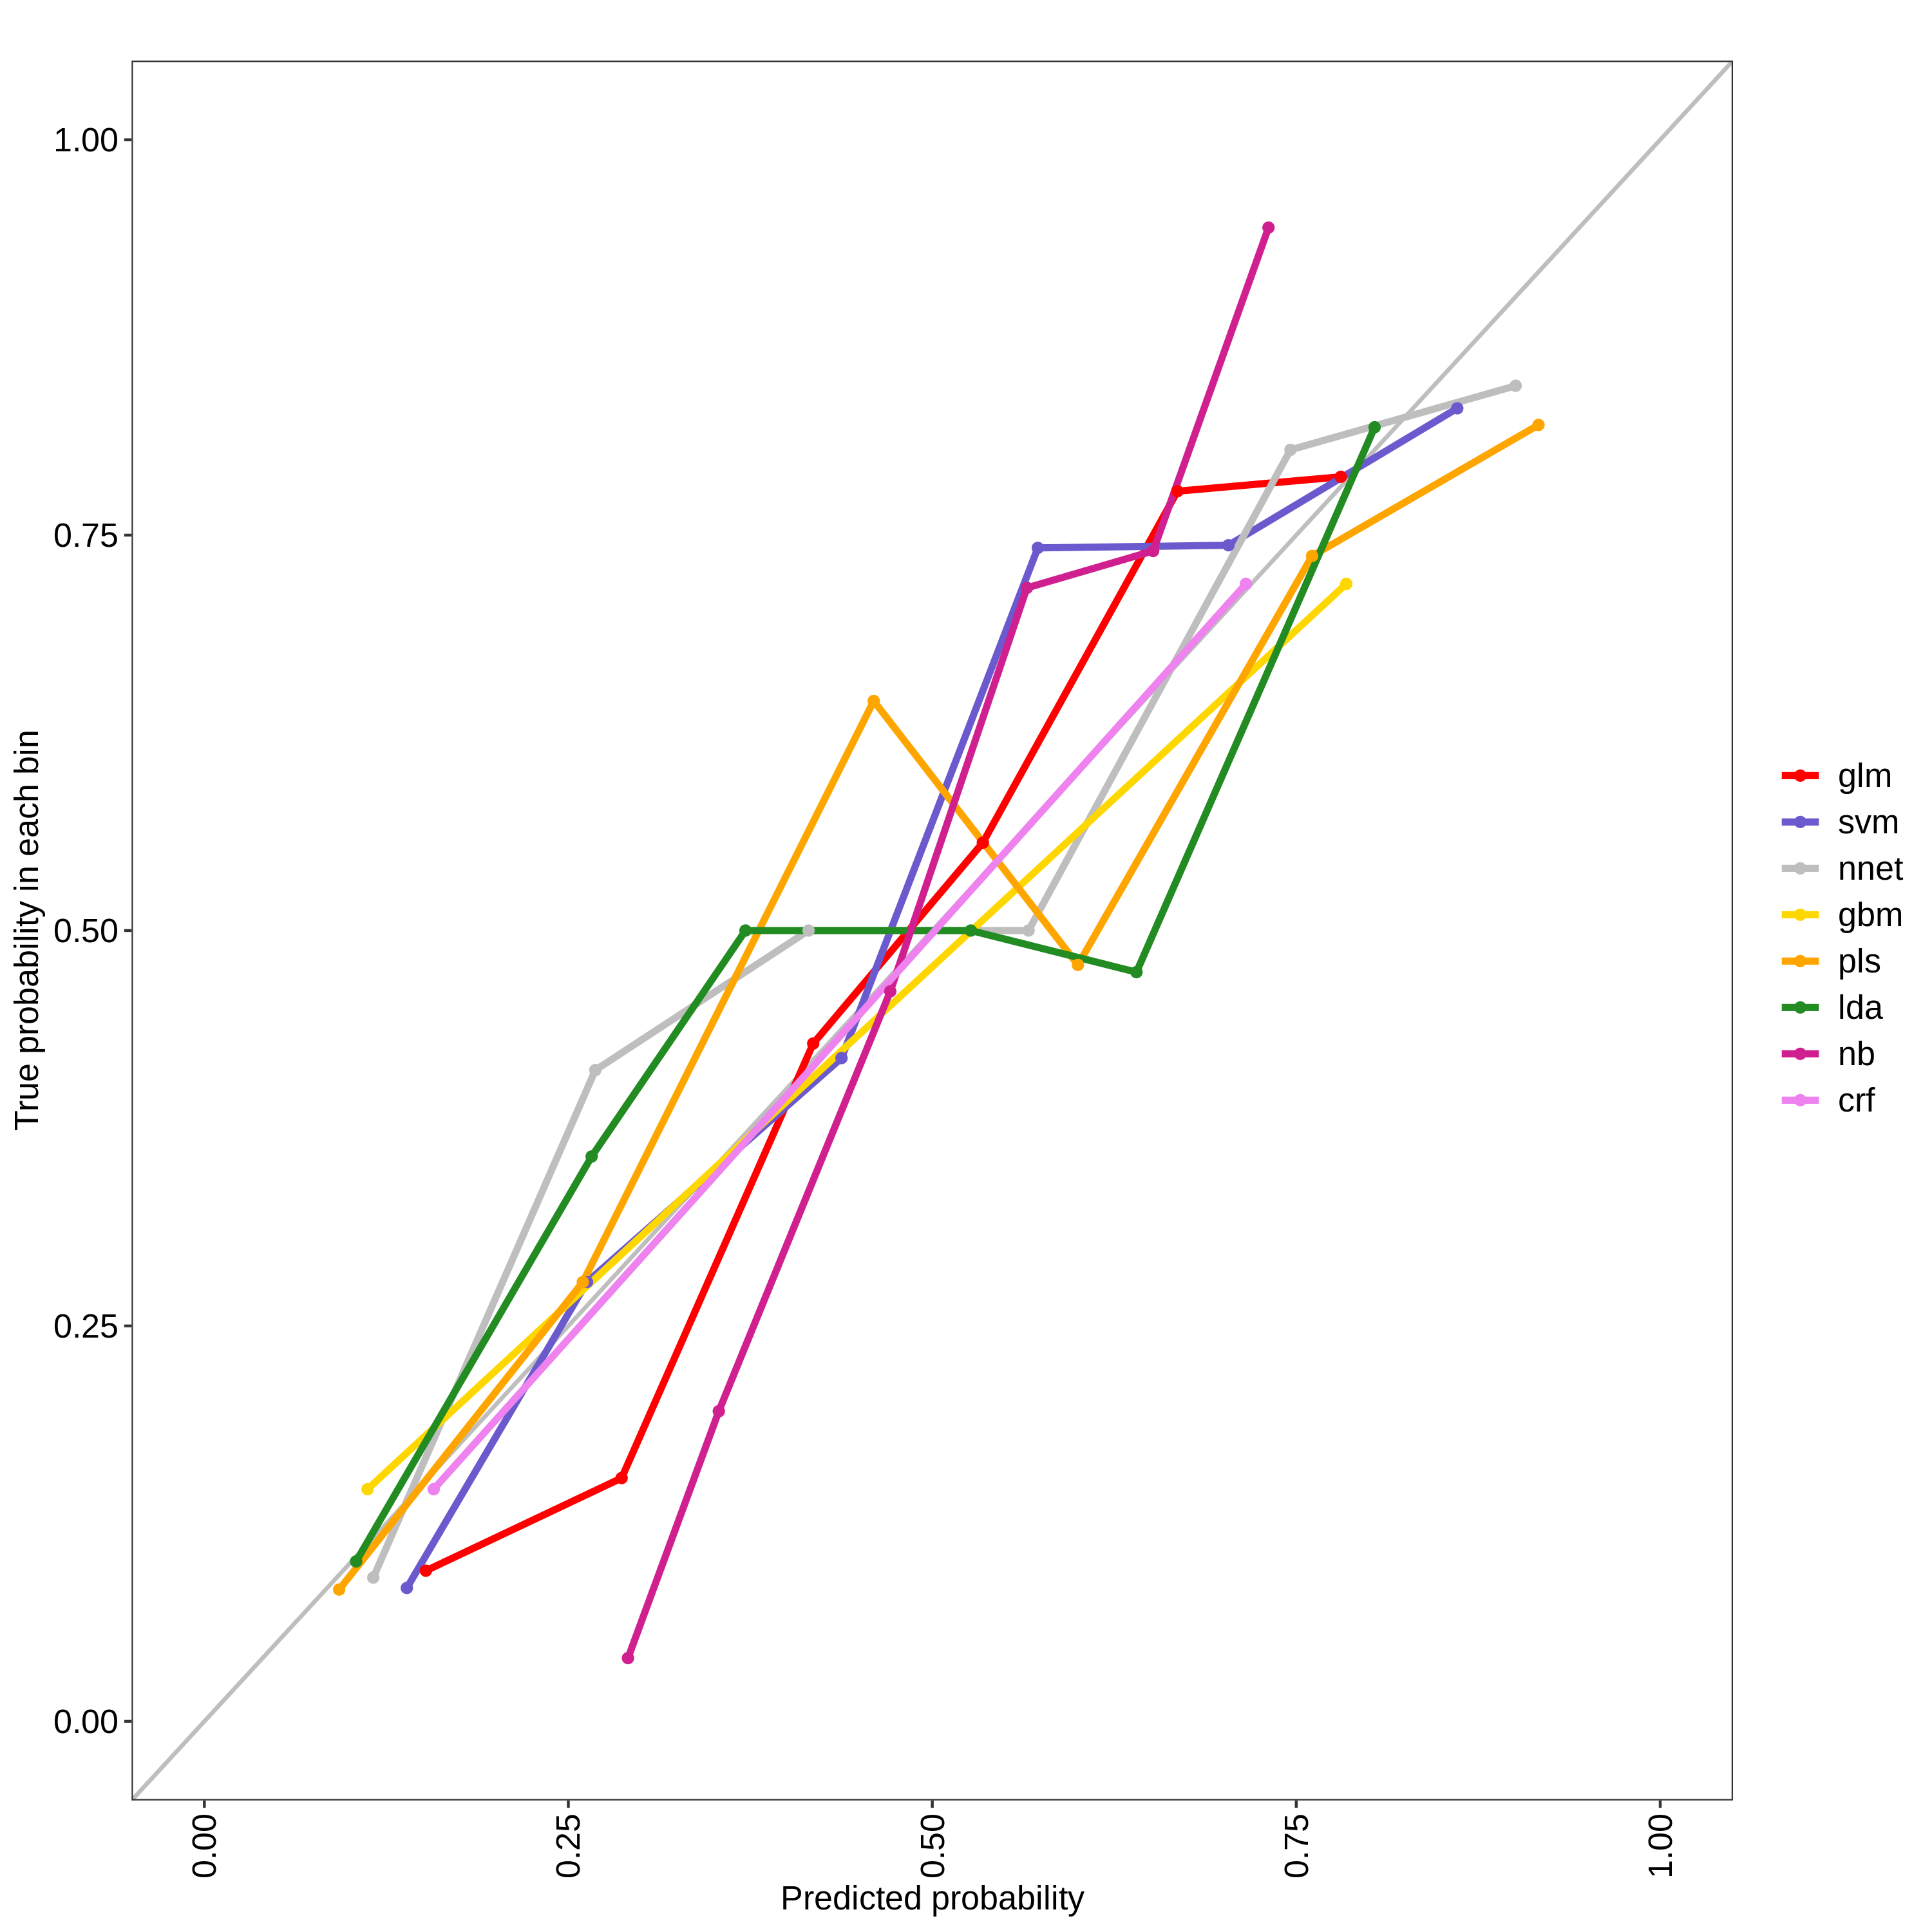

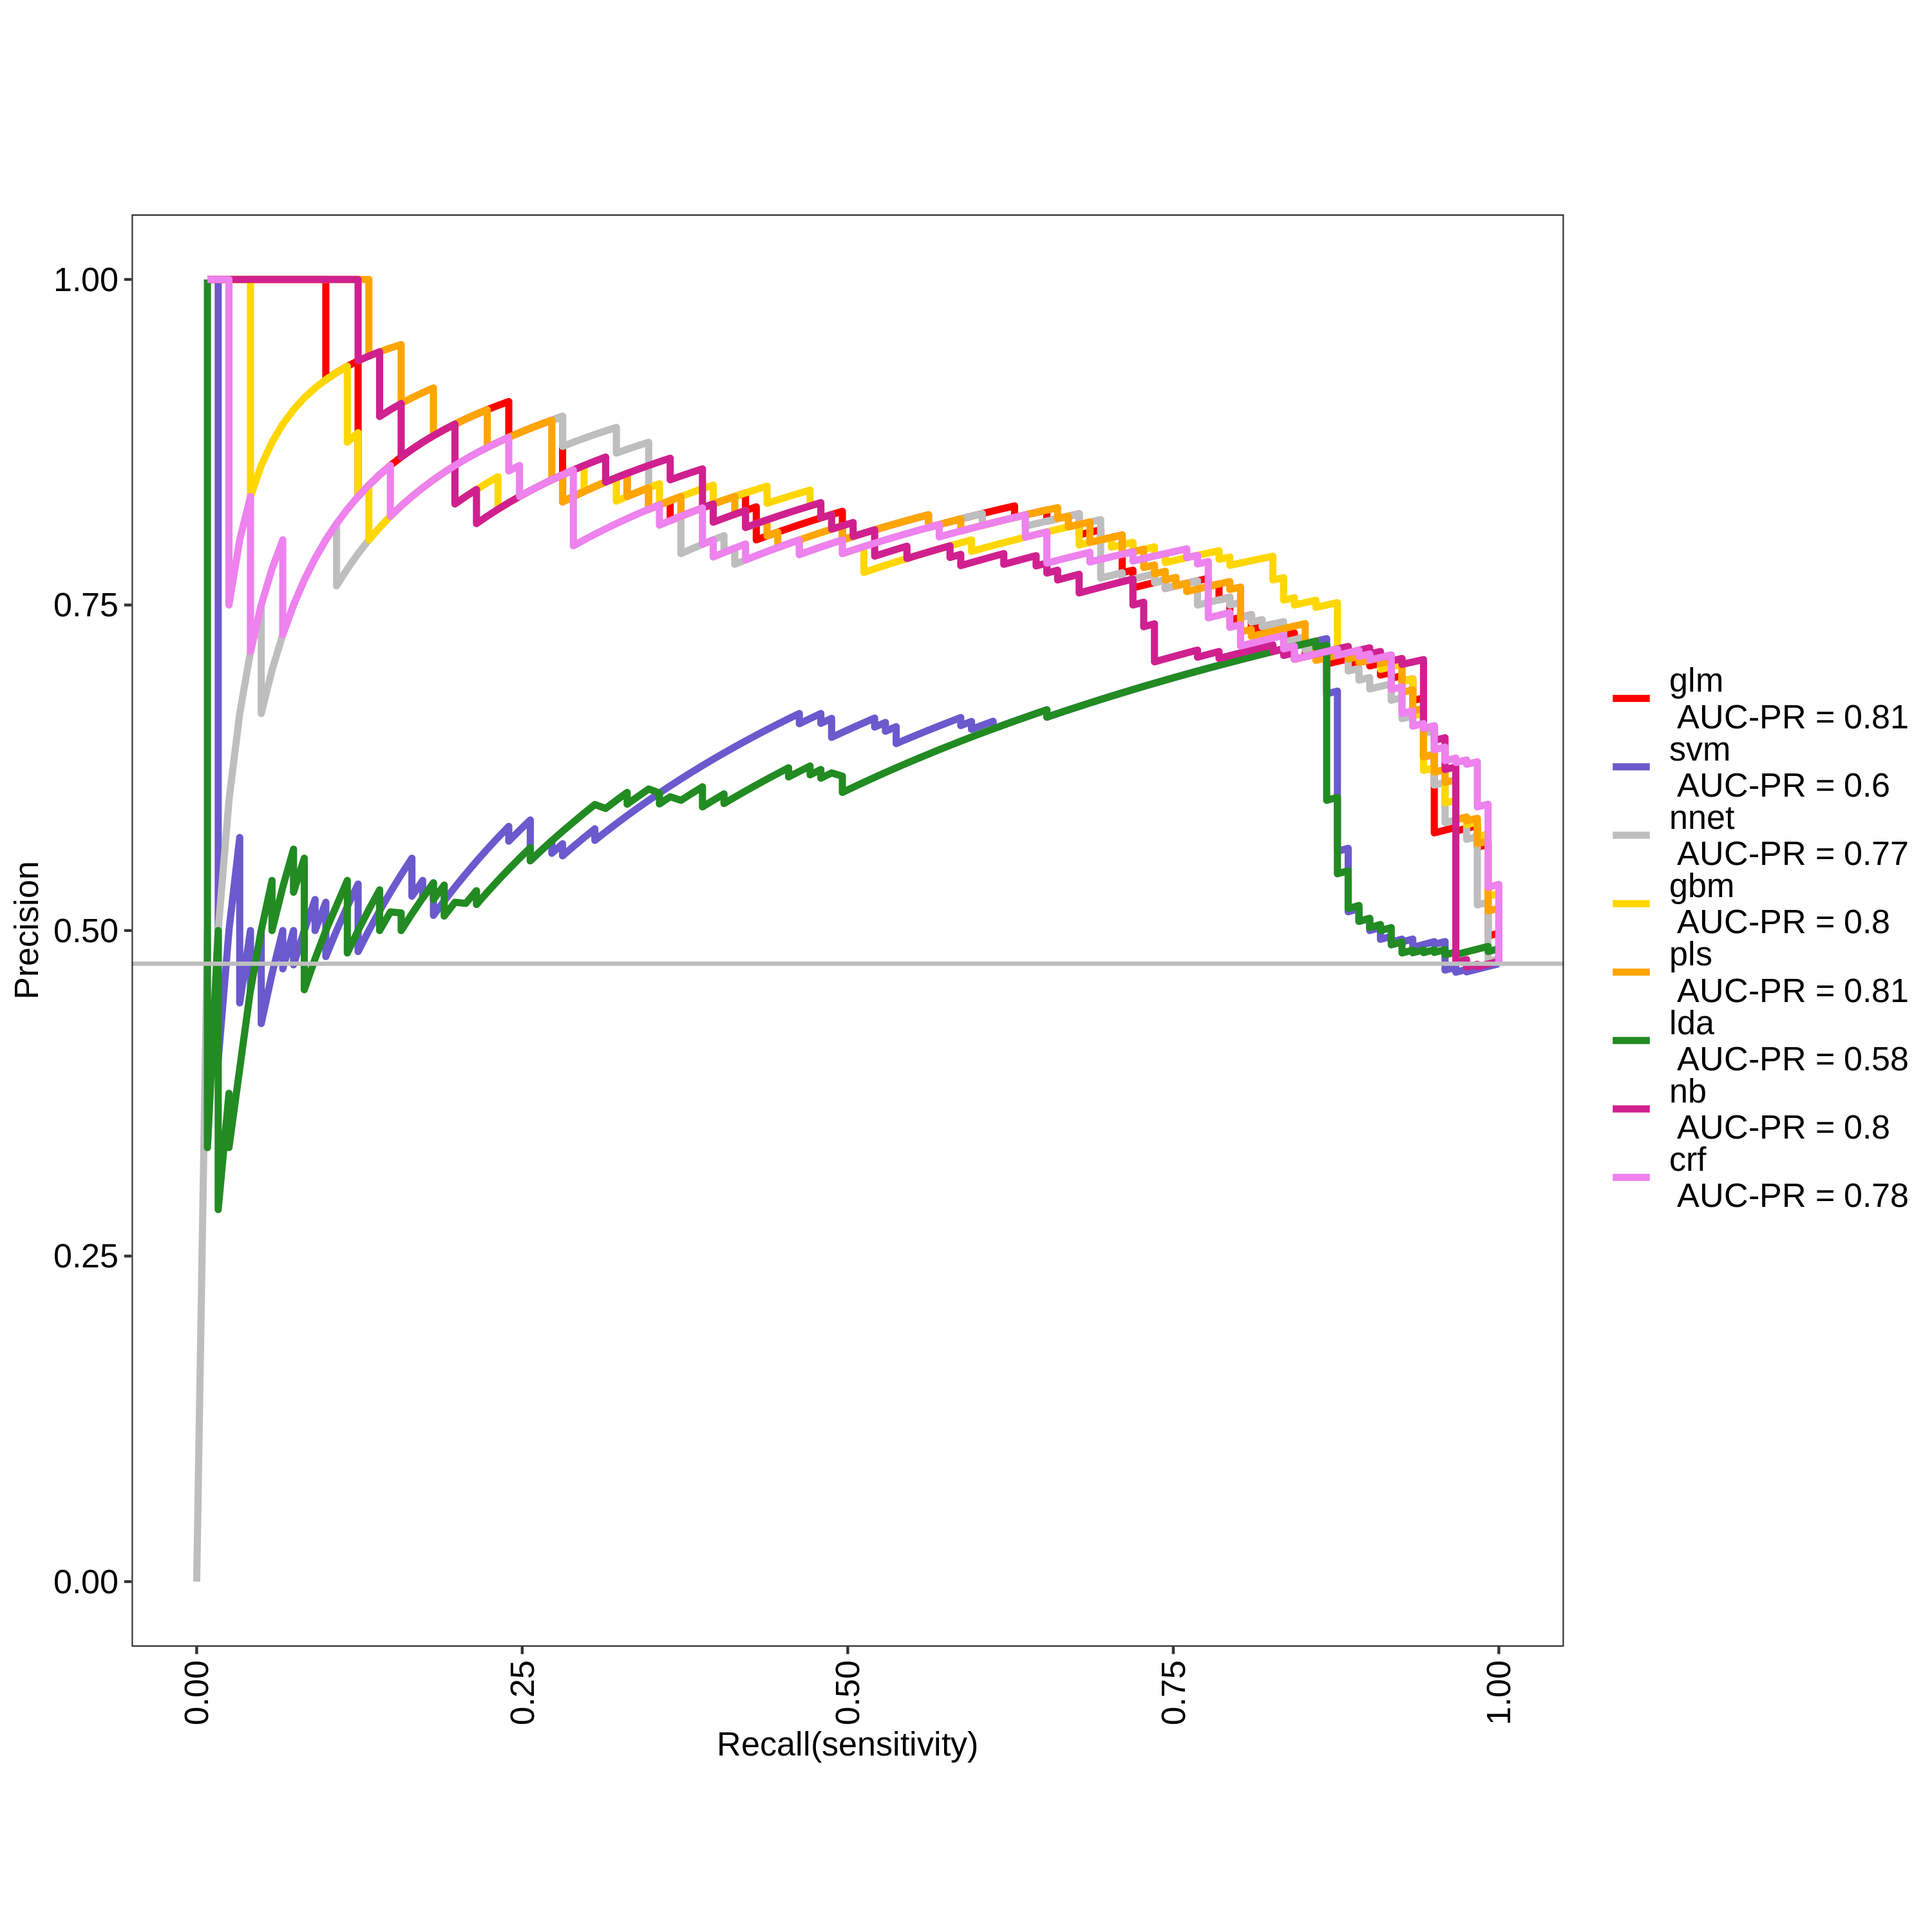

glm Optimal Informedness = 0.568706056494388

svm Optimal Informedness = 0.569261132354755

nnet Optimal Informedness = 0.570864684840262

gbm Optimal Informedness = 0.624953743678303

pls Optimal Informedness = 0.582336252621192

lda Optimal Informedness = 0.561798445787591

nb Optimal Informedness = 0.591402491673862

crf Optimal Informedness = 0.582829653385963

glm AUC-ROC = 0.85

svm AUC-ROC = 0.71

nnet AUC-ROC = 0.84

gbm AUC-ROC = 0.86

pls AUC-ROC = 0.85

lda AUC-ROC = 0.7

nb AUC-ROC = 0.83

crf AUC-ROC = 0.85



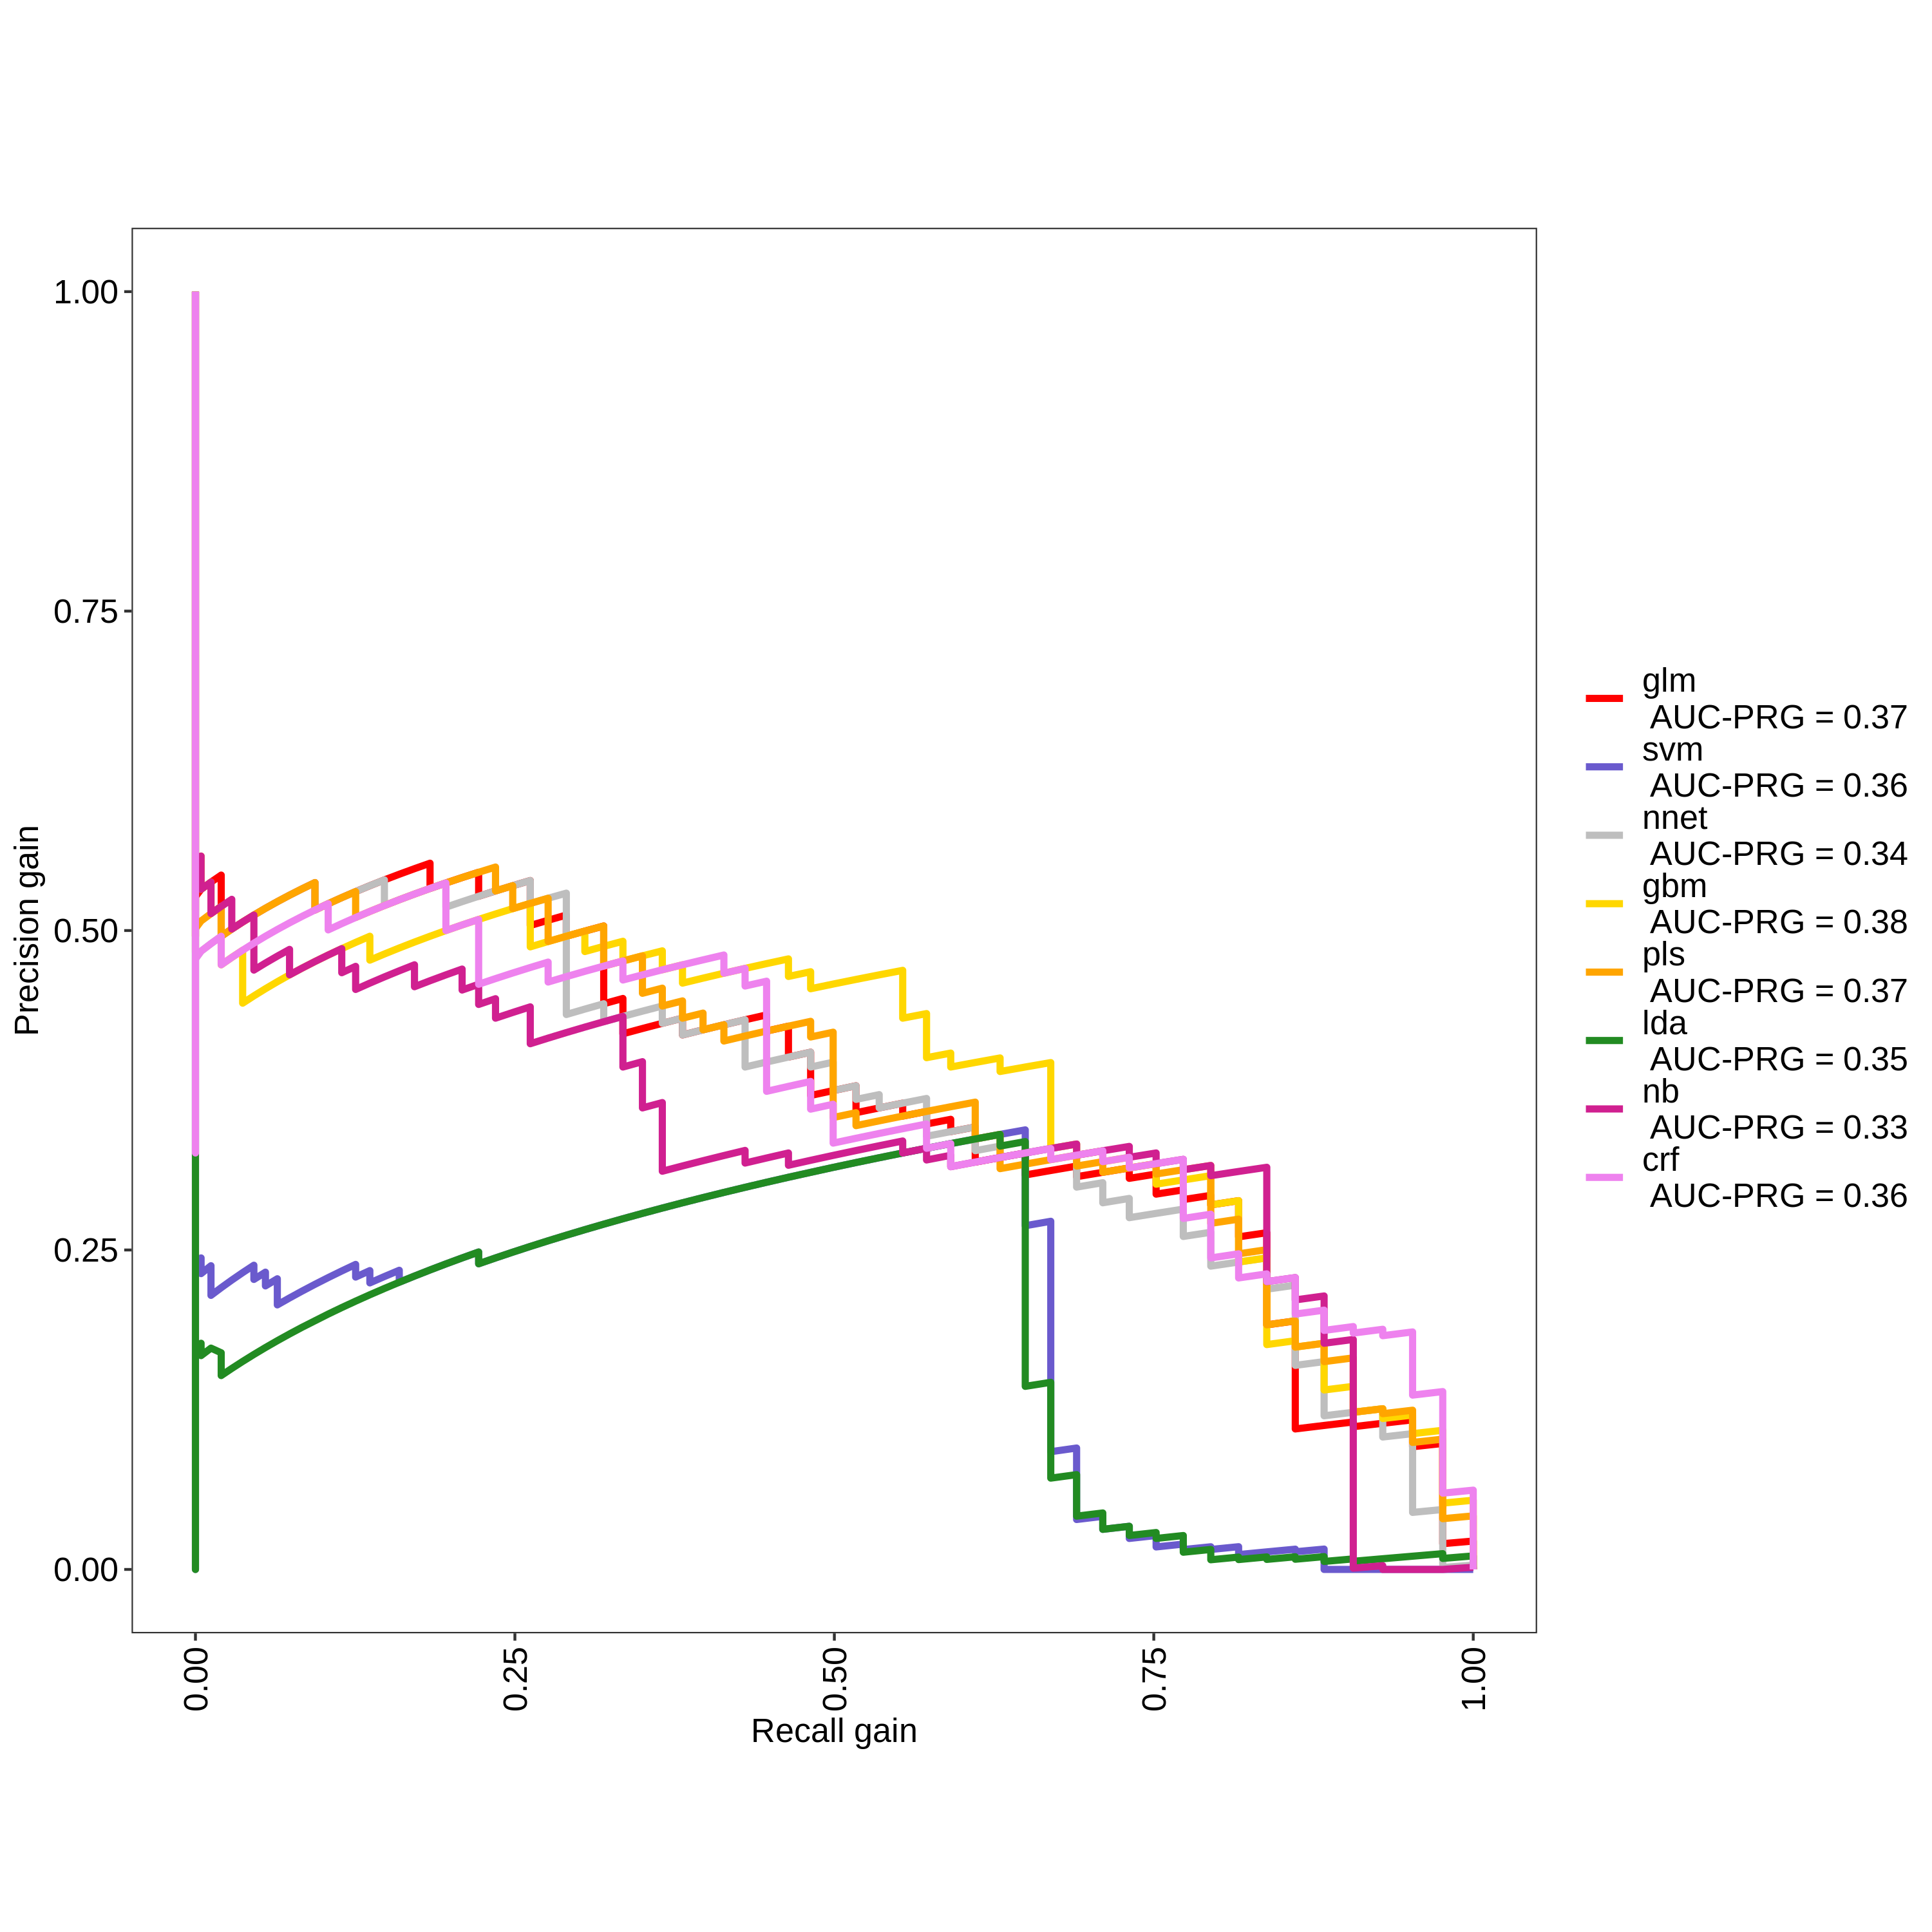

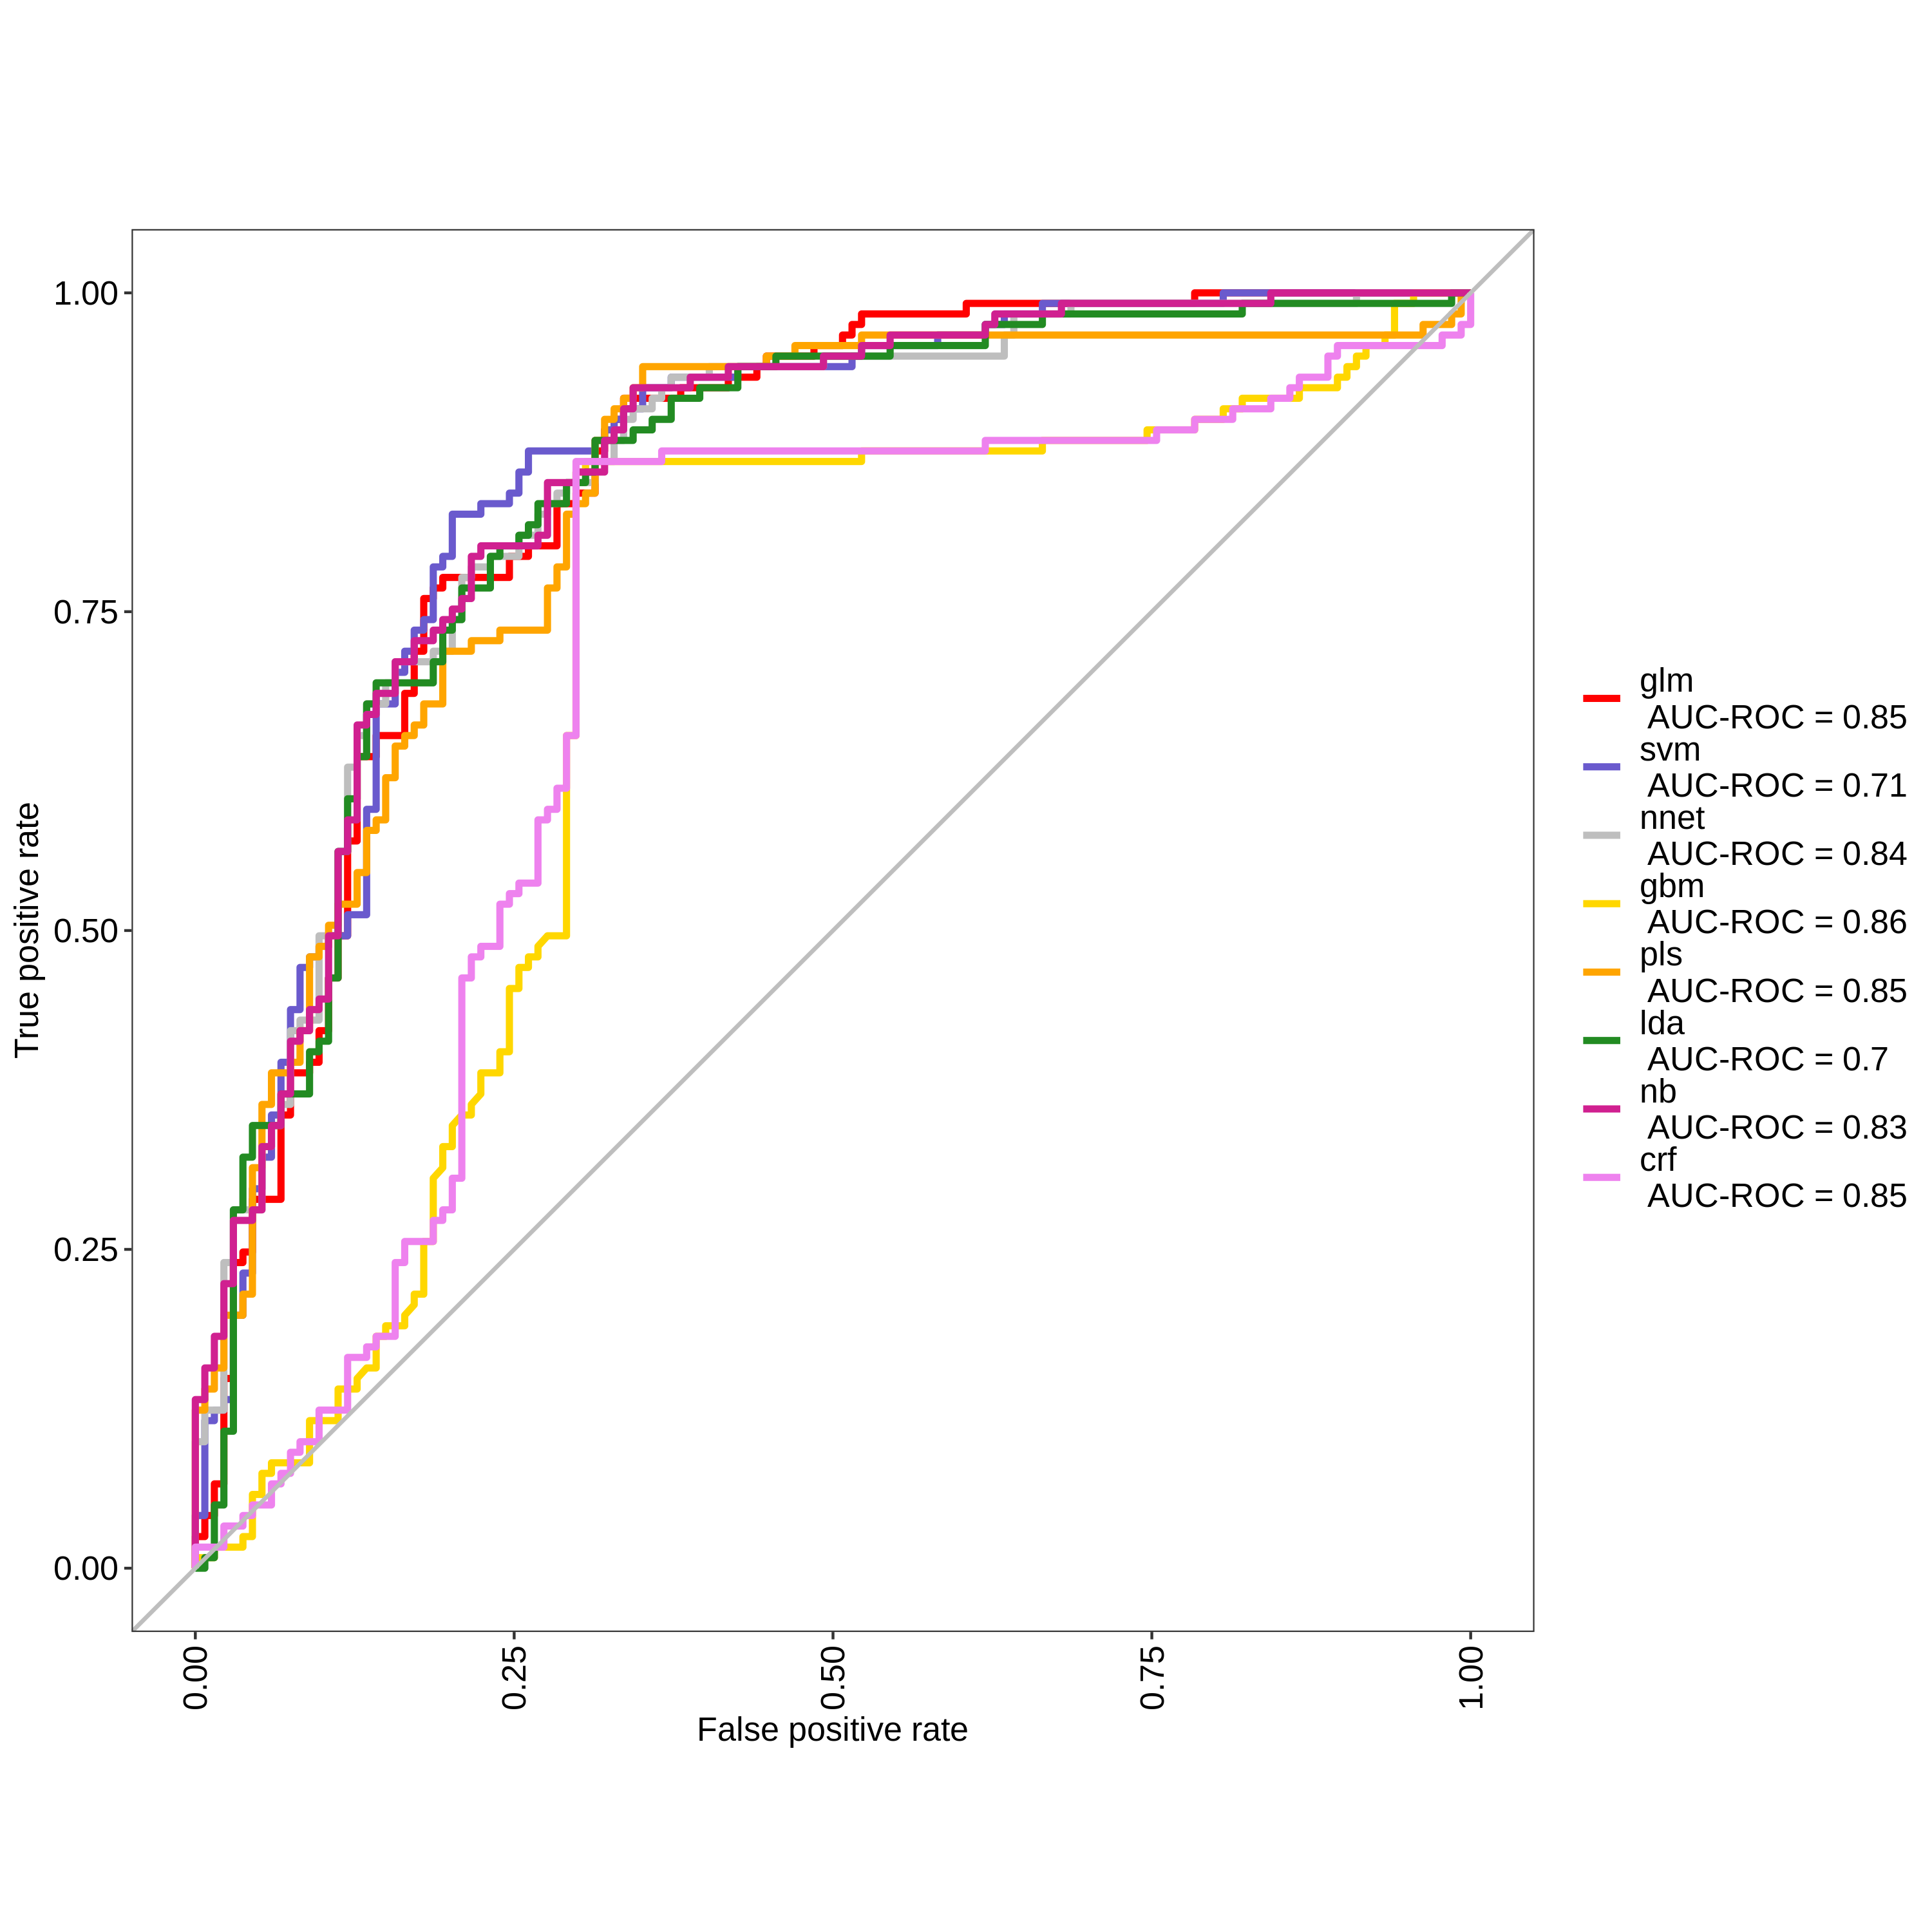

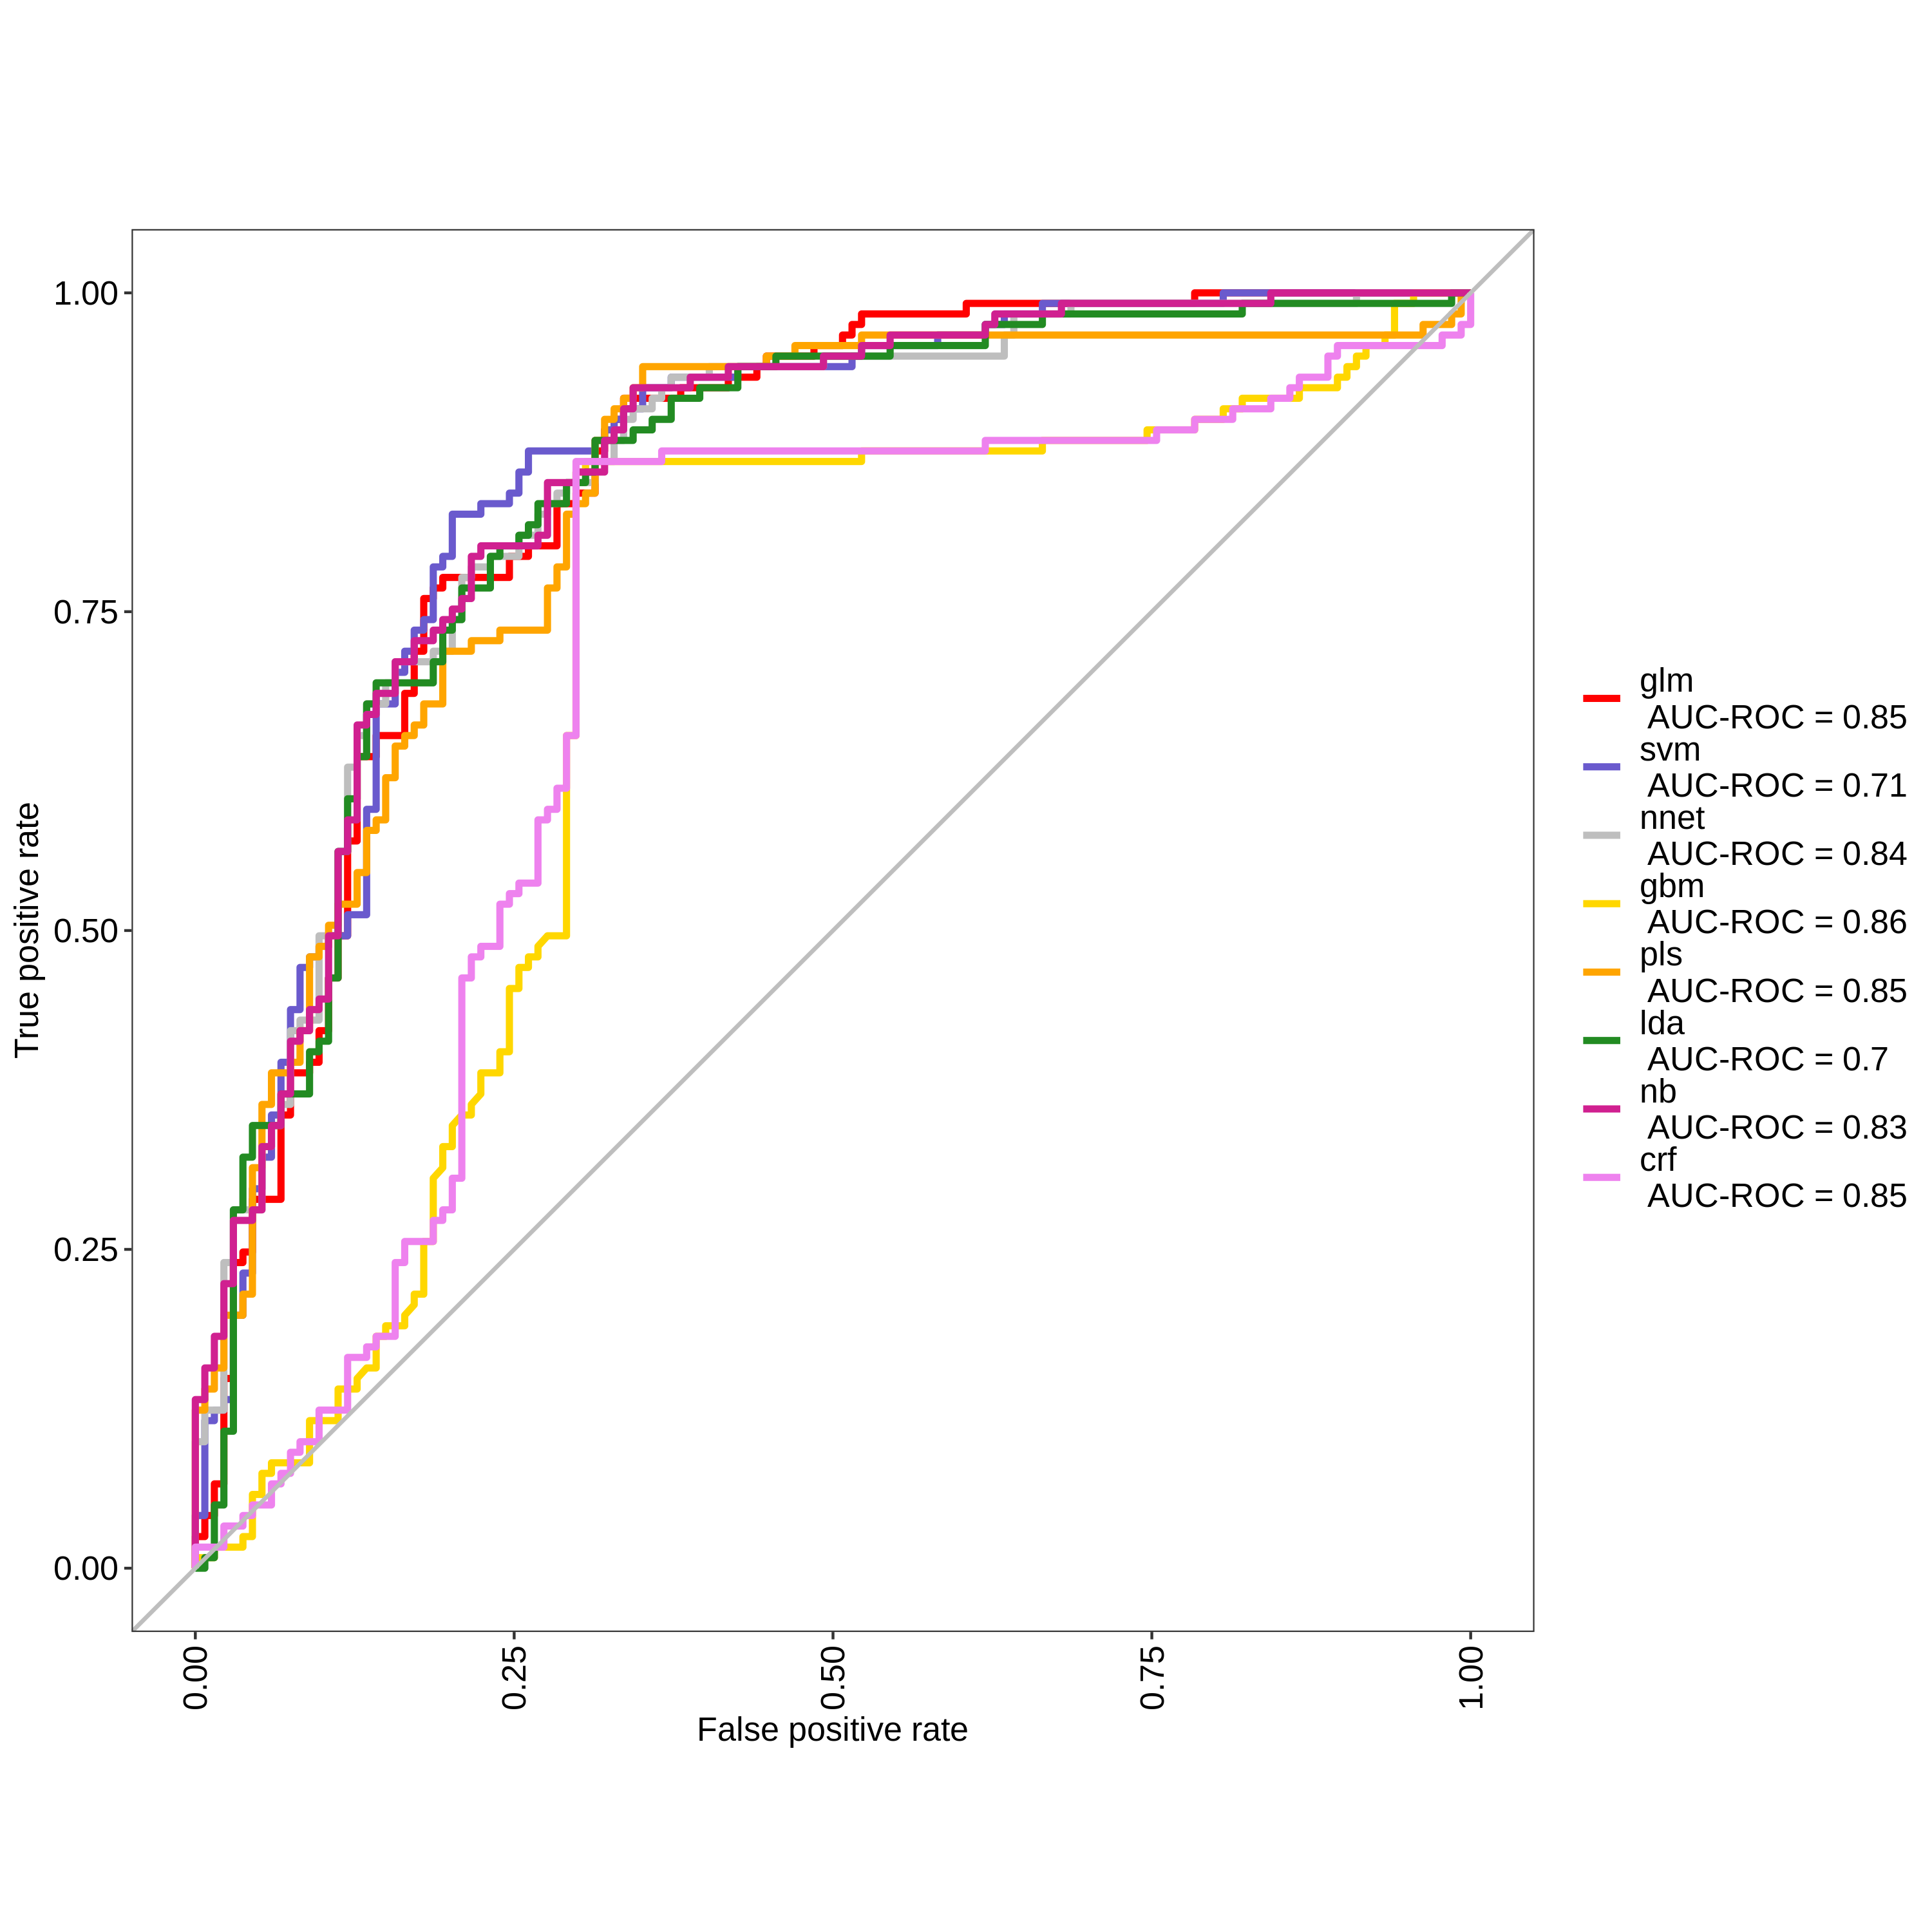

In [73]:
inp_glm <- train(Response ~ .,data=mod_inp_mat,
              method="glmnet",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))
inp_svm <- train(Response ~ .,data=mod_inp_mat,
              method="svmLinear2",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))
inp_nnet <- train(Response ~ .,data=mod_inp_mat,
              method="nnet",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))
inp_gbm <- train(Response ~ .,data=mod_inp_mat,
              method="gbm",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))
inp_pls <- train(Response ~ .,data=mod_inp_mat,
              method="pls",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))
inp_lda <- train(Response ~ .,data=mod_inp_mat,
              method="stepLDA",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))
inp_nb <- train(Response ~ .,data=mod_inp_mat,
              method="naive_bayes",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))
inp_crf <- train(Response ~ .,data=mod_inp_mat,
              method="cforest",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)
res_glm <- evalm(list(inp_glm, inp_svm, inp_nnet, inp_gbm, inp_pls, inp_lda, inp_nb, inp_crf),
             gnames=c("glm", "svm", "nnet", "gbm", 
                      "pls", "lda", "nb", "crf"))
res_glm$roc

In [74]:
mod_inp_mat2 <- mod_inp_mat[,c("Response", "Age", "Gender")]

# weights:  5
initial  value 161.212495 
iter  10 value 156.653447
iter  20 value 154.282235
iter  30 value 153.969866
iter  40 value 153.894337
iter  50 value 153.810014
iter  60 value 153.706821
iter  70 value 153.701546
iter  80 value 153.684565
iter  90 value 153.673247
iter 100 value 153.663056
final  value 153.663056 
stopped after 100 iterations
# weights:  13
initial  value 162.056508 
iter  10 value 156.136073
iter  20 value 154.256610
iter  30 value 152.655704
iter  40 value 152.231112
iter  50 value 151.599425
iter  60 value 151.068311
iter  70 value 151.056479
iter  80 value 150.981735
iter  90 value 150.875154
iter 100 value 150.730279
final  value 150.730279 
stopped after 100 iterations
# weights:  21
initial  value 157.655662 
iter  10 value 155.441085
iter  20 value 153.289368
iter  30 value 151.467533
iter  40 value 151.263116
iter  50 value 151.136957
iter  60 value 151.050968
iter  70 value 150.917327
iter  80 value 150.638657
iter  90 value 150.457945
iter 100 valu

 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

229 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.53636;  in: "Age";  variables (1): Age 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        0.04 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.5913;  in: "Age";  variables (1): Age 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.042 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.56522;  in: "Age";  variables (1): Age 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        0.04 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

229 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.54585;  in: "Age";  variables (1): Age 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.041 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

229 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.55909;  in: "Age";  variables (1): Age 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.041 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

229 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.52411;  in: "Gender";  variables (1): Gender 
correctness rate: 0.57628;  in: "Age";  variables (2): Gender, Age 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        0.04 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.52174;  in: "Age";  variables (1): Age 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.041 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.50435;  in: "Age";  variables (1): Age 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.048 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

229 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.56739;  in: "Age";  variables (1): Age 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.041 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.55217;  in: "Age";  variables (1): Age 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.041 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.55217;  in: "Age";  variables (1): Age 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        0.04 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

229 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.52411;  in: "Gender";  variables (1): Gender 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        0.04 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

229 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.56759;  in: "Age";  variables (1): Age 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        0.04 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

229 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.58142;  in: "Age";  variables (1): Age 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.041 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.55652;  in: "Age";  variables (1): Age 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.046 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.53043;  in: "Age";  variables (1): Age 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.041 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

229 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.51976;  in: "Age";  variables (1): Age 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        0.04 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.53913;  in: "Age";  variables (1): Age 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        0.04 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

229 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.5587;  in: "Age";  variables (1): Age 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.041 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.58696;  in: "Age";  variables (1): Age 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.041 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

229 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.59407;  in: "Age";  variables (1): Age 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.046 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.56087;  in: "Age";  variables (1): Age 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        0.04 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.53478;  in: "Age";  variables (1): Age 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        0.04 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

229 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.53696;  in: "Age";  variables (1): Age 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.049 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

229 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.52411;  in: "Gender";  variables (1): Gender 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        0.04 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.54783;  in: "Age";  variables (1): Age 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.044 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.56522;  in: "Age";  variables (1): Age 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.041 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

230 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.54348;  in: "Age";  variables (1): Age 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.049 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

229 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.56324;  in: "Age";  variables (1): Age 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.043 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

229 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.5502;  in: "Age";  variables (1): Age 

 hr.elapsed min.elapsed sec.elapsed 
       0.00        0.00        0.04 



 `stepwise classification', using 10-fold cross-validated correctness rate of method lda'.

255 observations of 2 variables in 2 classes; direction: both

stop criterion: improvement less than 5%.



correctness rate: 0.56954;  in: "Age";  variables (1): Age 

 hr.elapsed min.elapsed sec.elapsed 
      0.000       0.000       0.041 

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .



***MLeval: Machine Learning Model Evaluation***

Input: caret train function object

Averaging probs.

Group 1 type: repeatedcv

Group 2 type: repeatedcv

Group 3 type: repeatedcv

Group 4 type: repeatedcv

Group 5 type: repeatedcv

Group 6 type: repeatedcv

Group 7 type: repeatedcv

Group 8 type: repeatedcv

Observations: 2040

Number of groups: 8

Observations per group: 255

Positive: Y

Negative: N

Group: glm

Positive: 121

Negative: 134

Group: svm

Positive: 121

Negative: 134

Group: nnet

Positive: 121

Negative: 134

Group: gbm

Positive: 121

Negative: 134

Group: pls

Positive: 121

Negative: 134

Group: lda

Positive: 121

Negative: 134

Group: nb

Positive: 121

Negative: 134

Group: crf

Positive: 121

Negative: 134

***Performance Metrics***



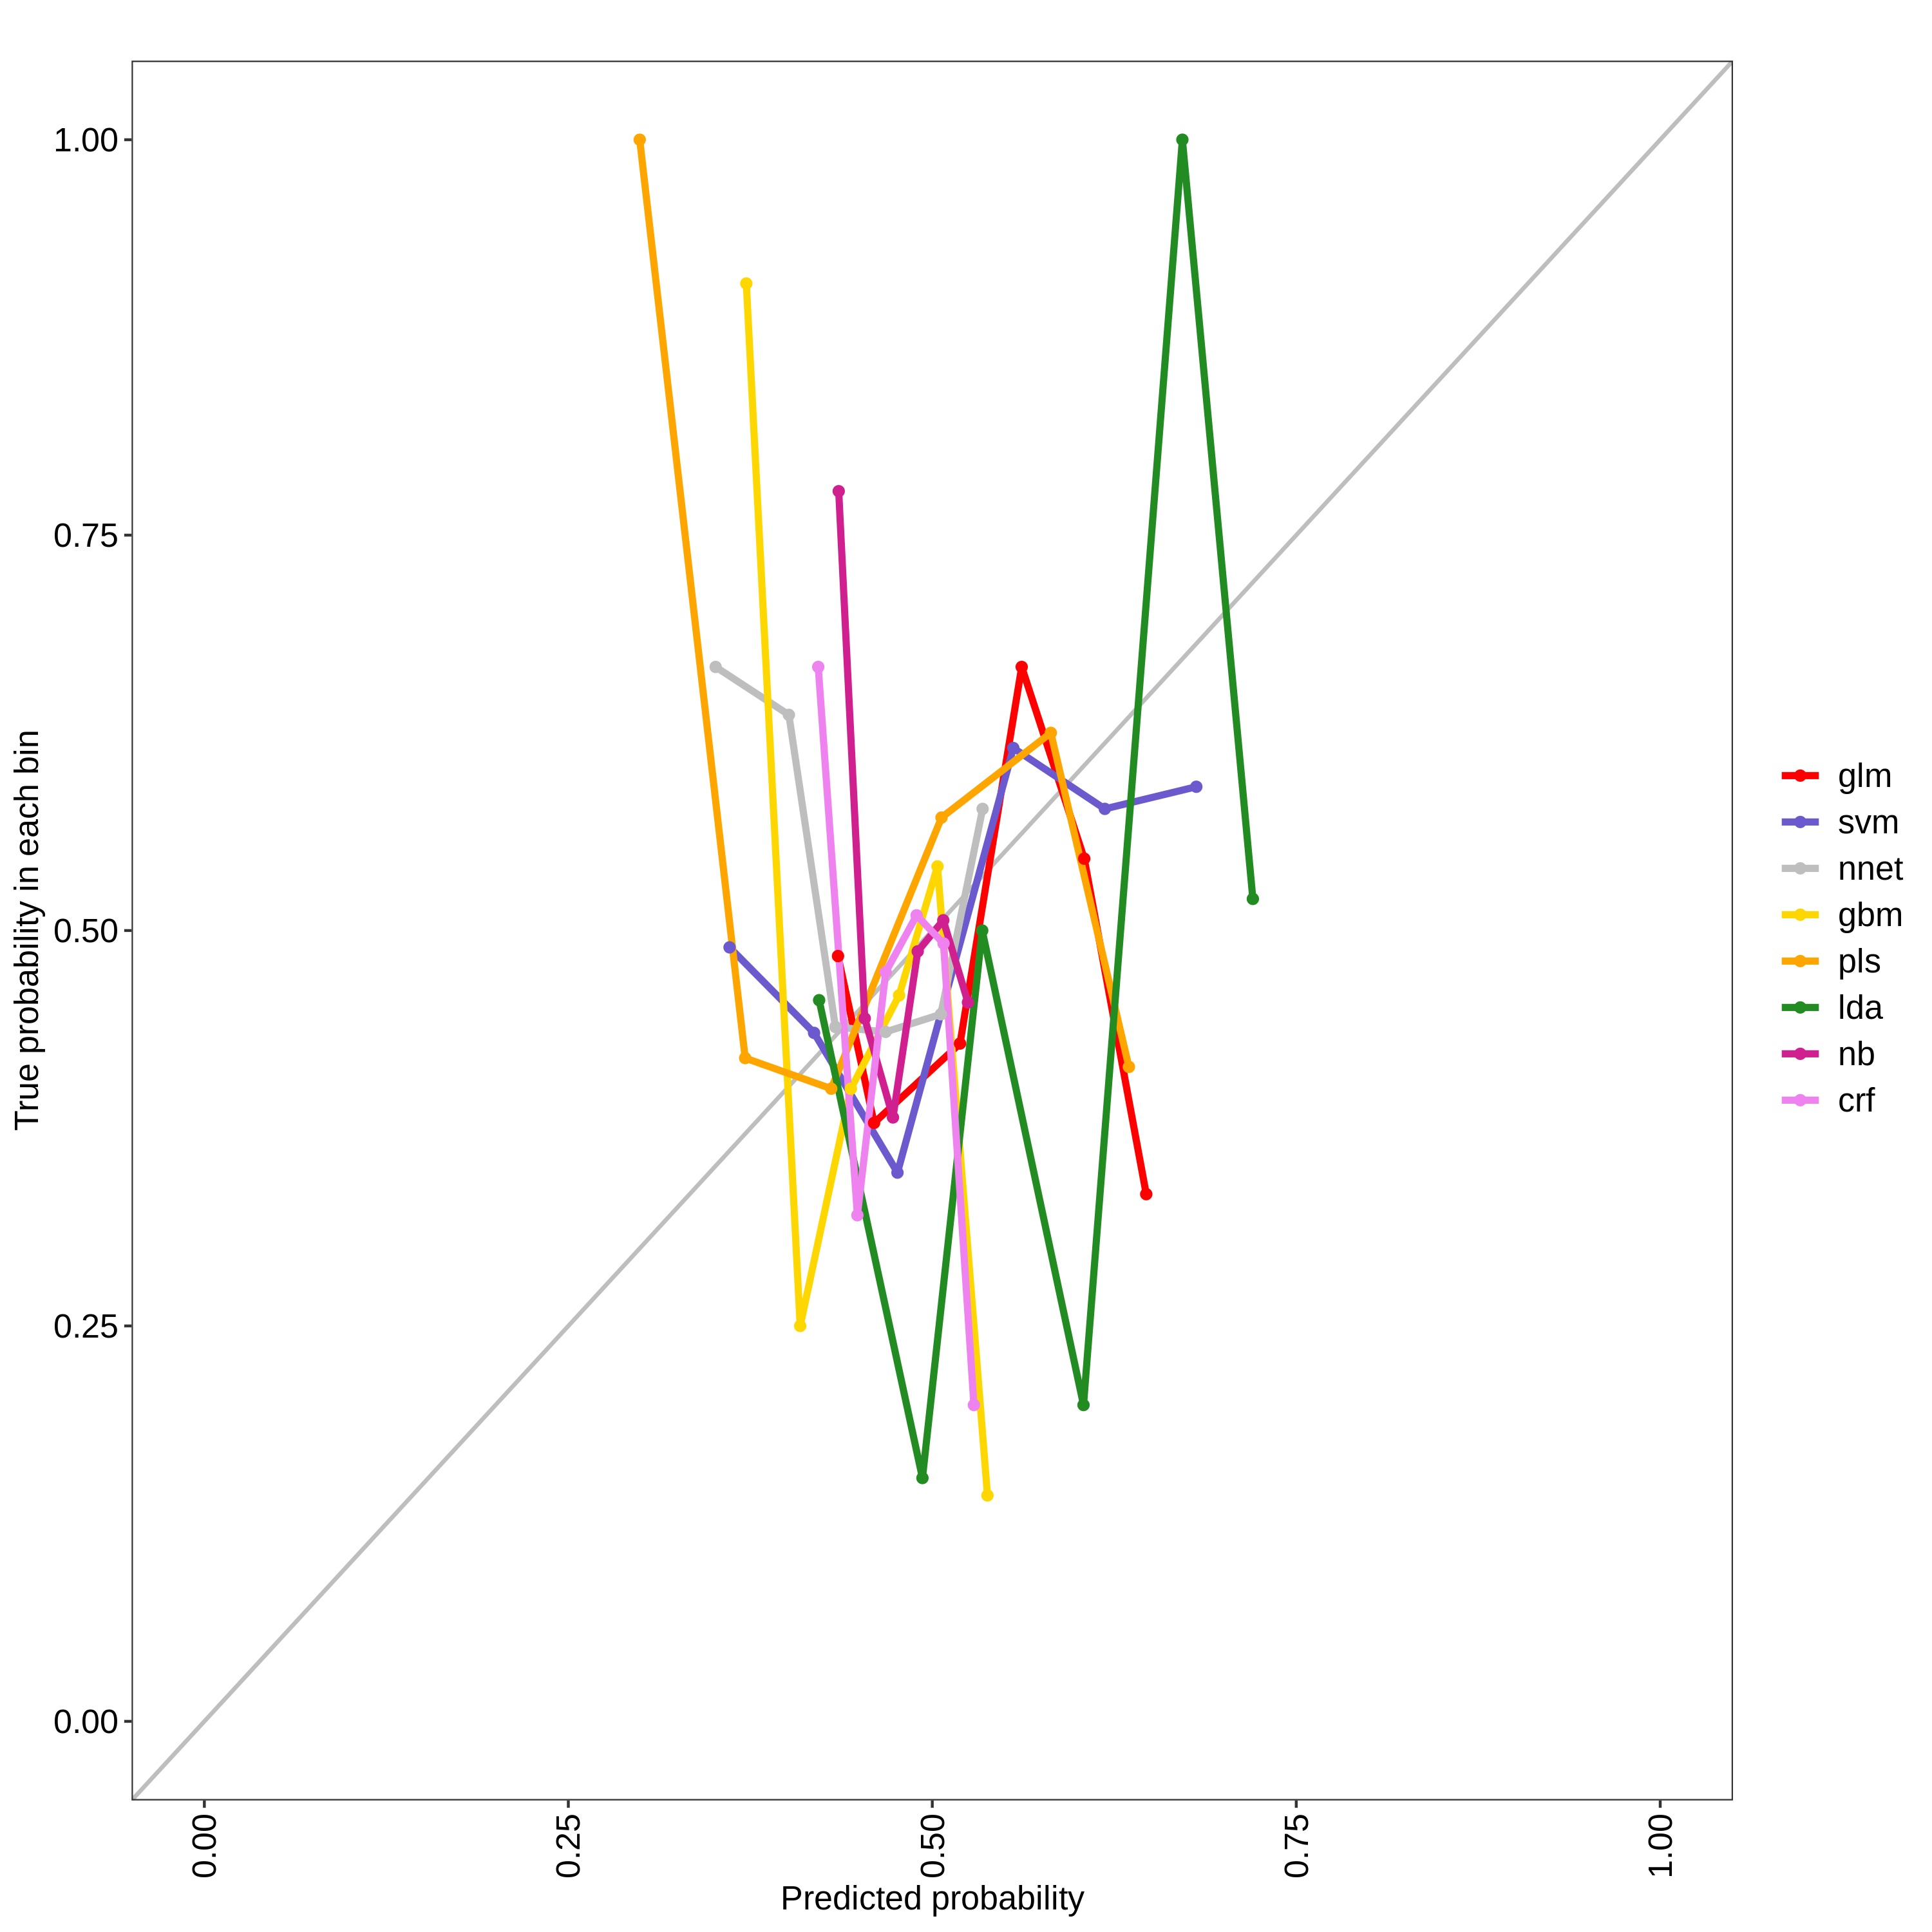

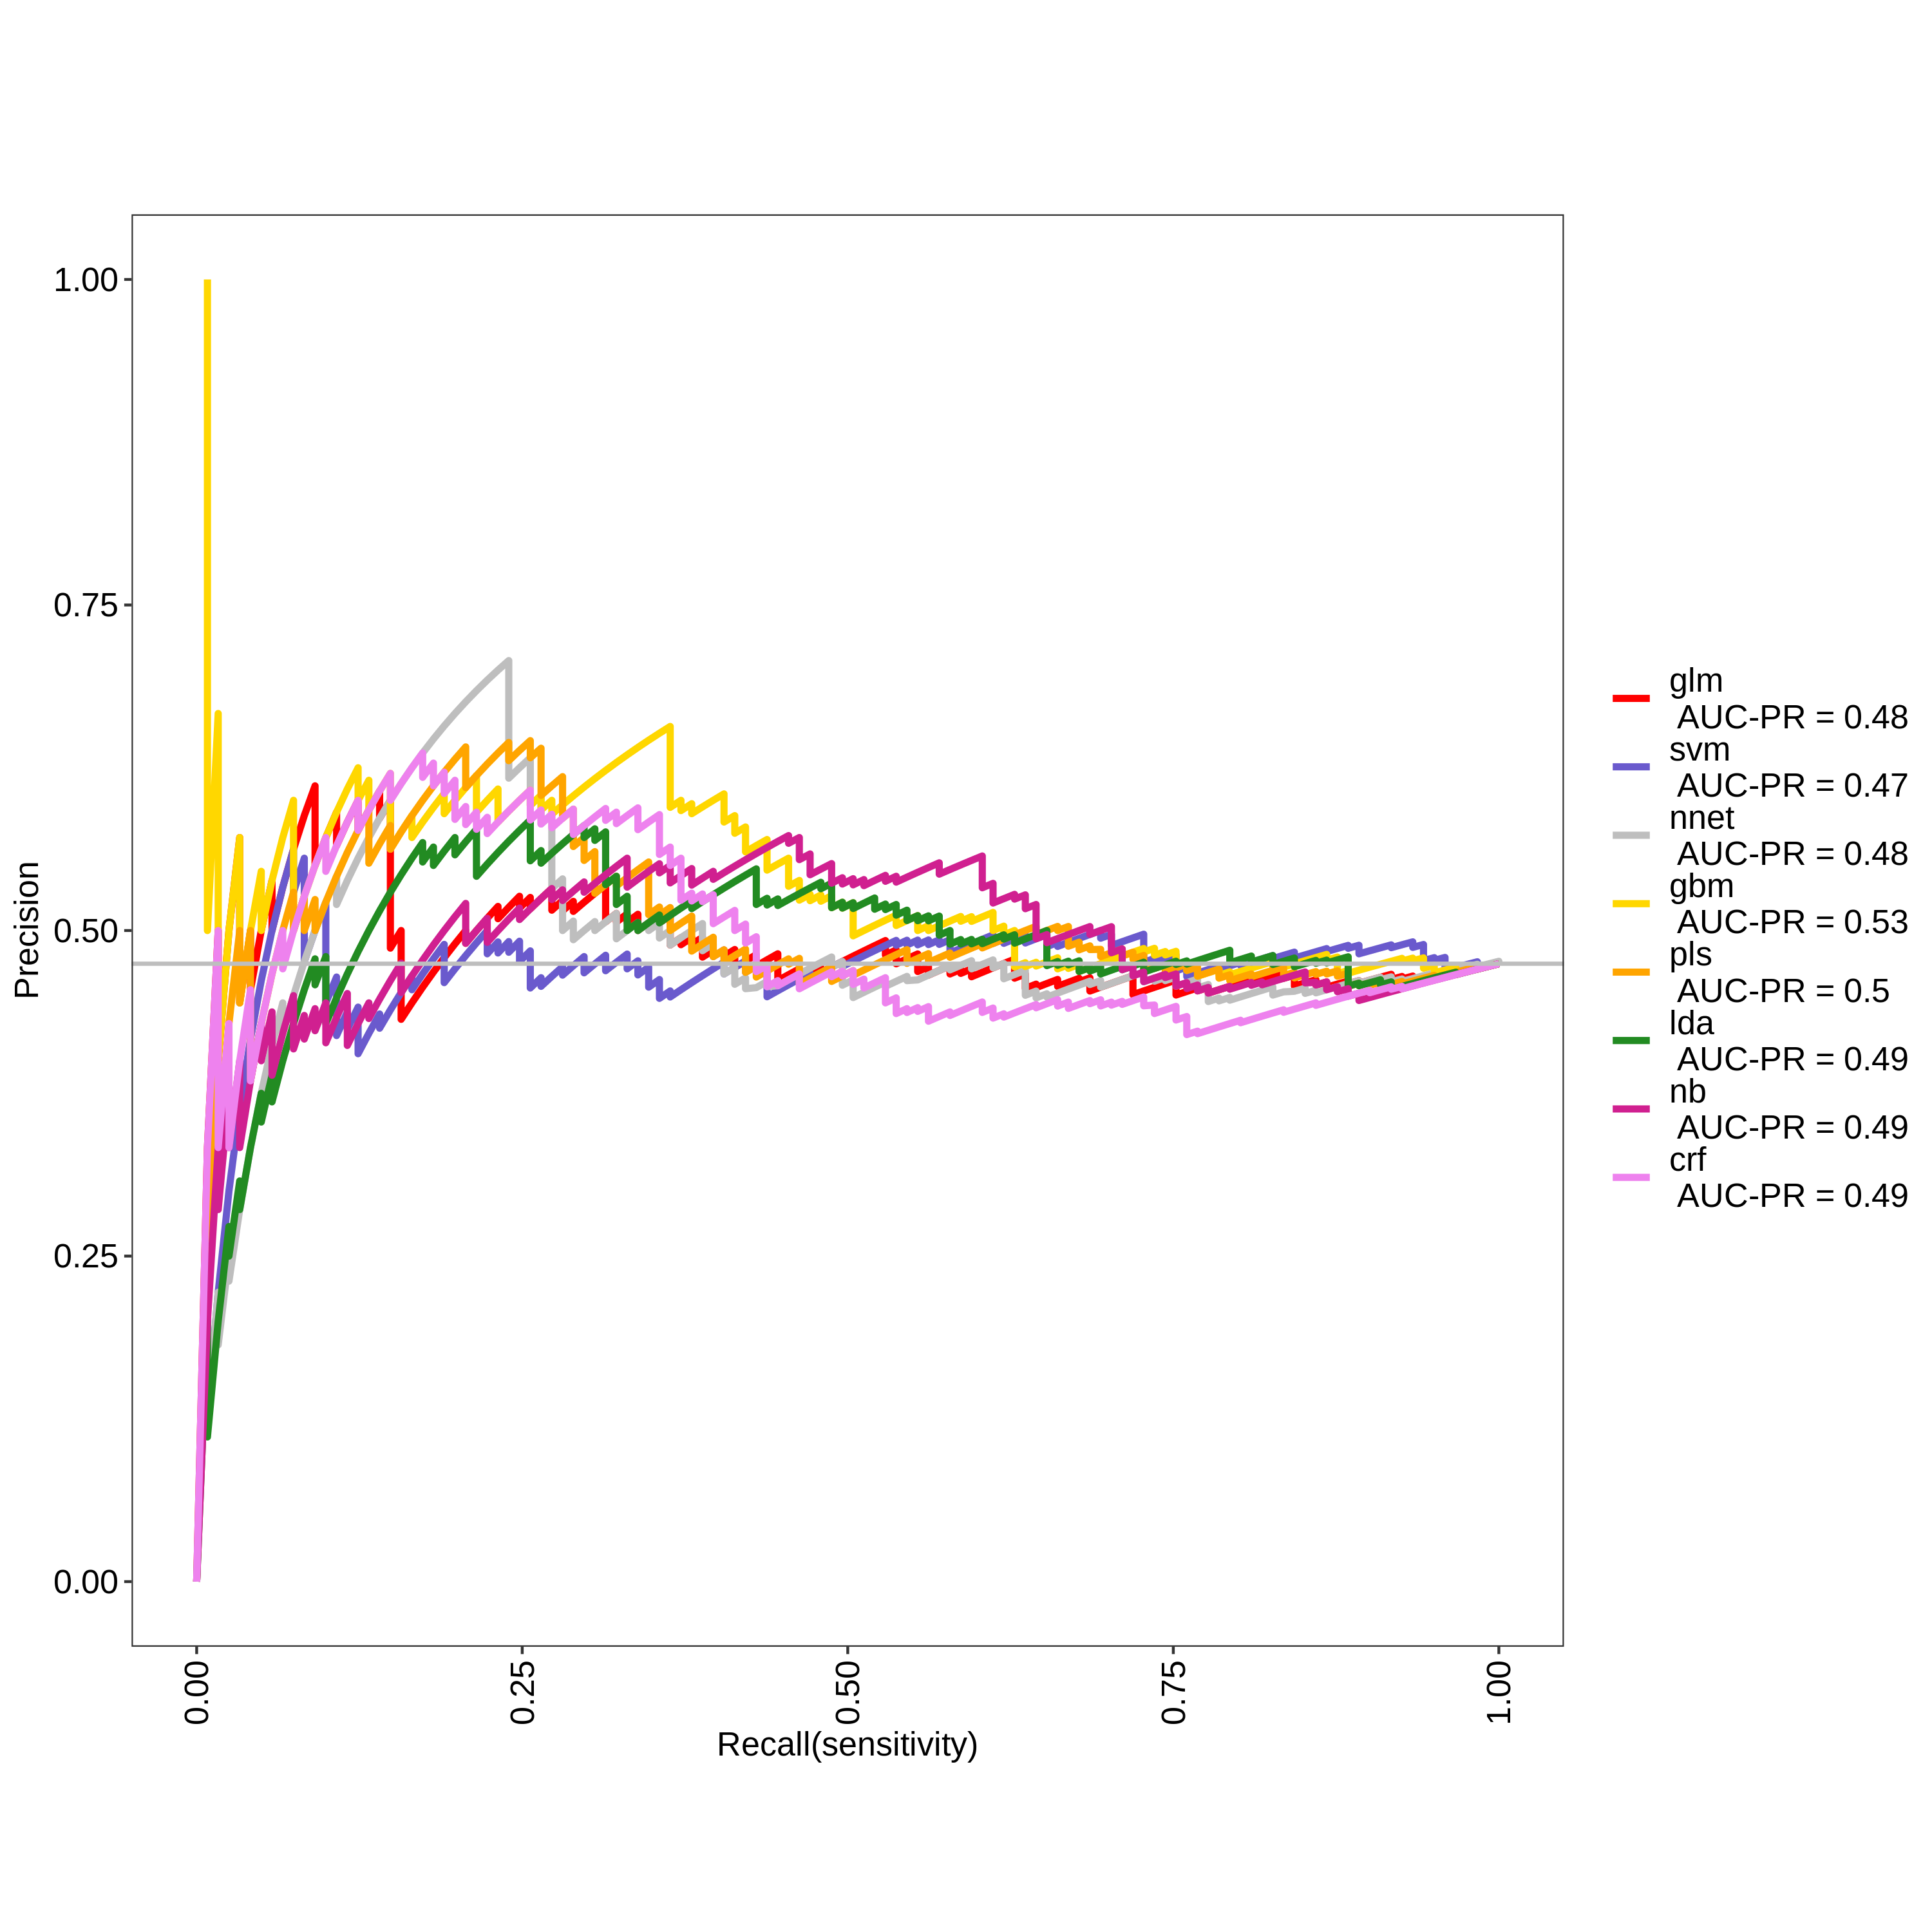

glm Optimal Informedness = 0.0677809300604415

svm Optimal Informedness = 0.0673492043912669

nnet Optimal Informedness = 0.150117182681633

gbm Optimal Informedness = 0.191994572591587

pls Optimal Informedness = 0.1301344517084

lda Optimal Informedness = 0.108856543727643

nb Optimal Informedness = 0.170469964228444

crf Optimal Informedness = 0.131491303811521

glm AUC-ROC = 0.49

svm AUC-ROC = 0.51

nnet AUC-ROC = 0.49

gbm AUC-ROC = 0.55

pls AUC-ROC = 0.52

lda AUC-ROC = 0.53

nb AUC-ROC = 0.53

crf AUC-ROC = 0.48



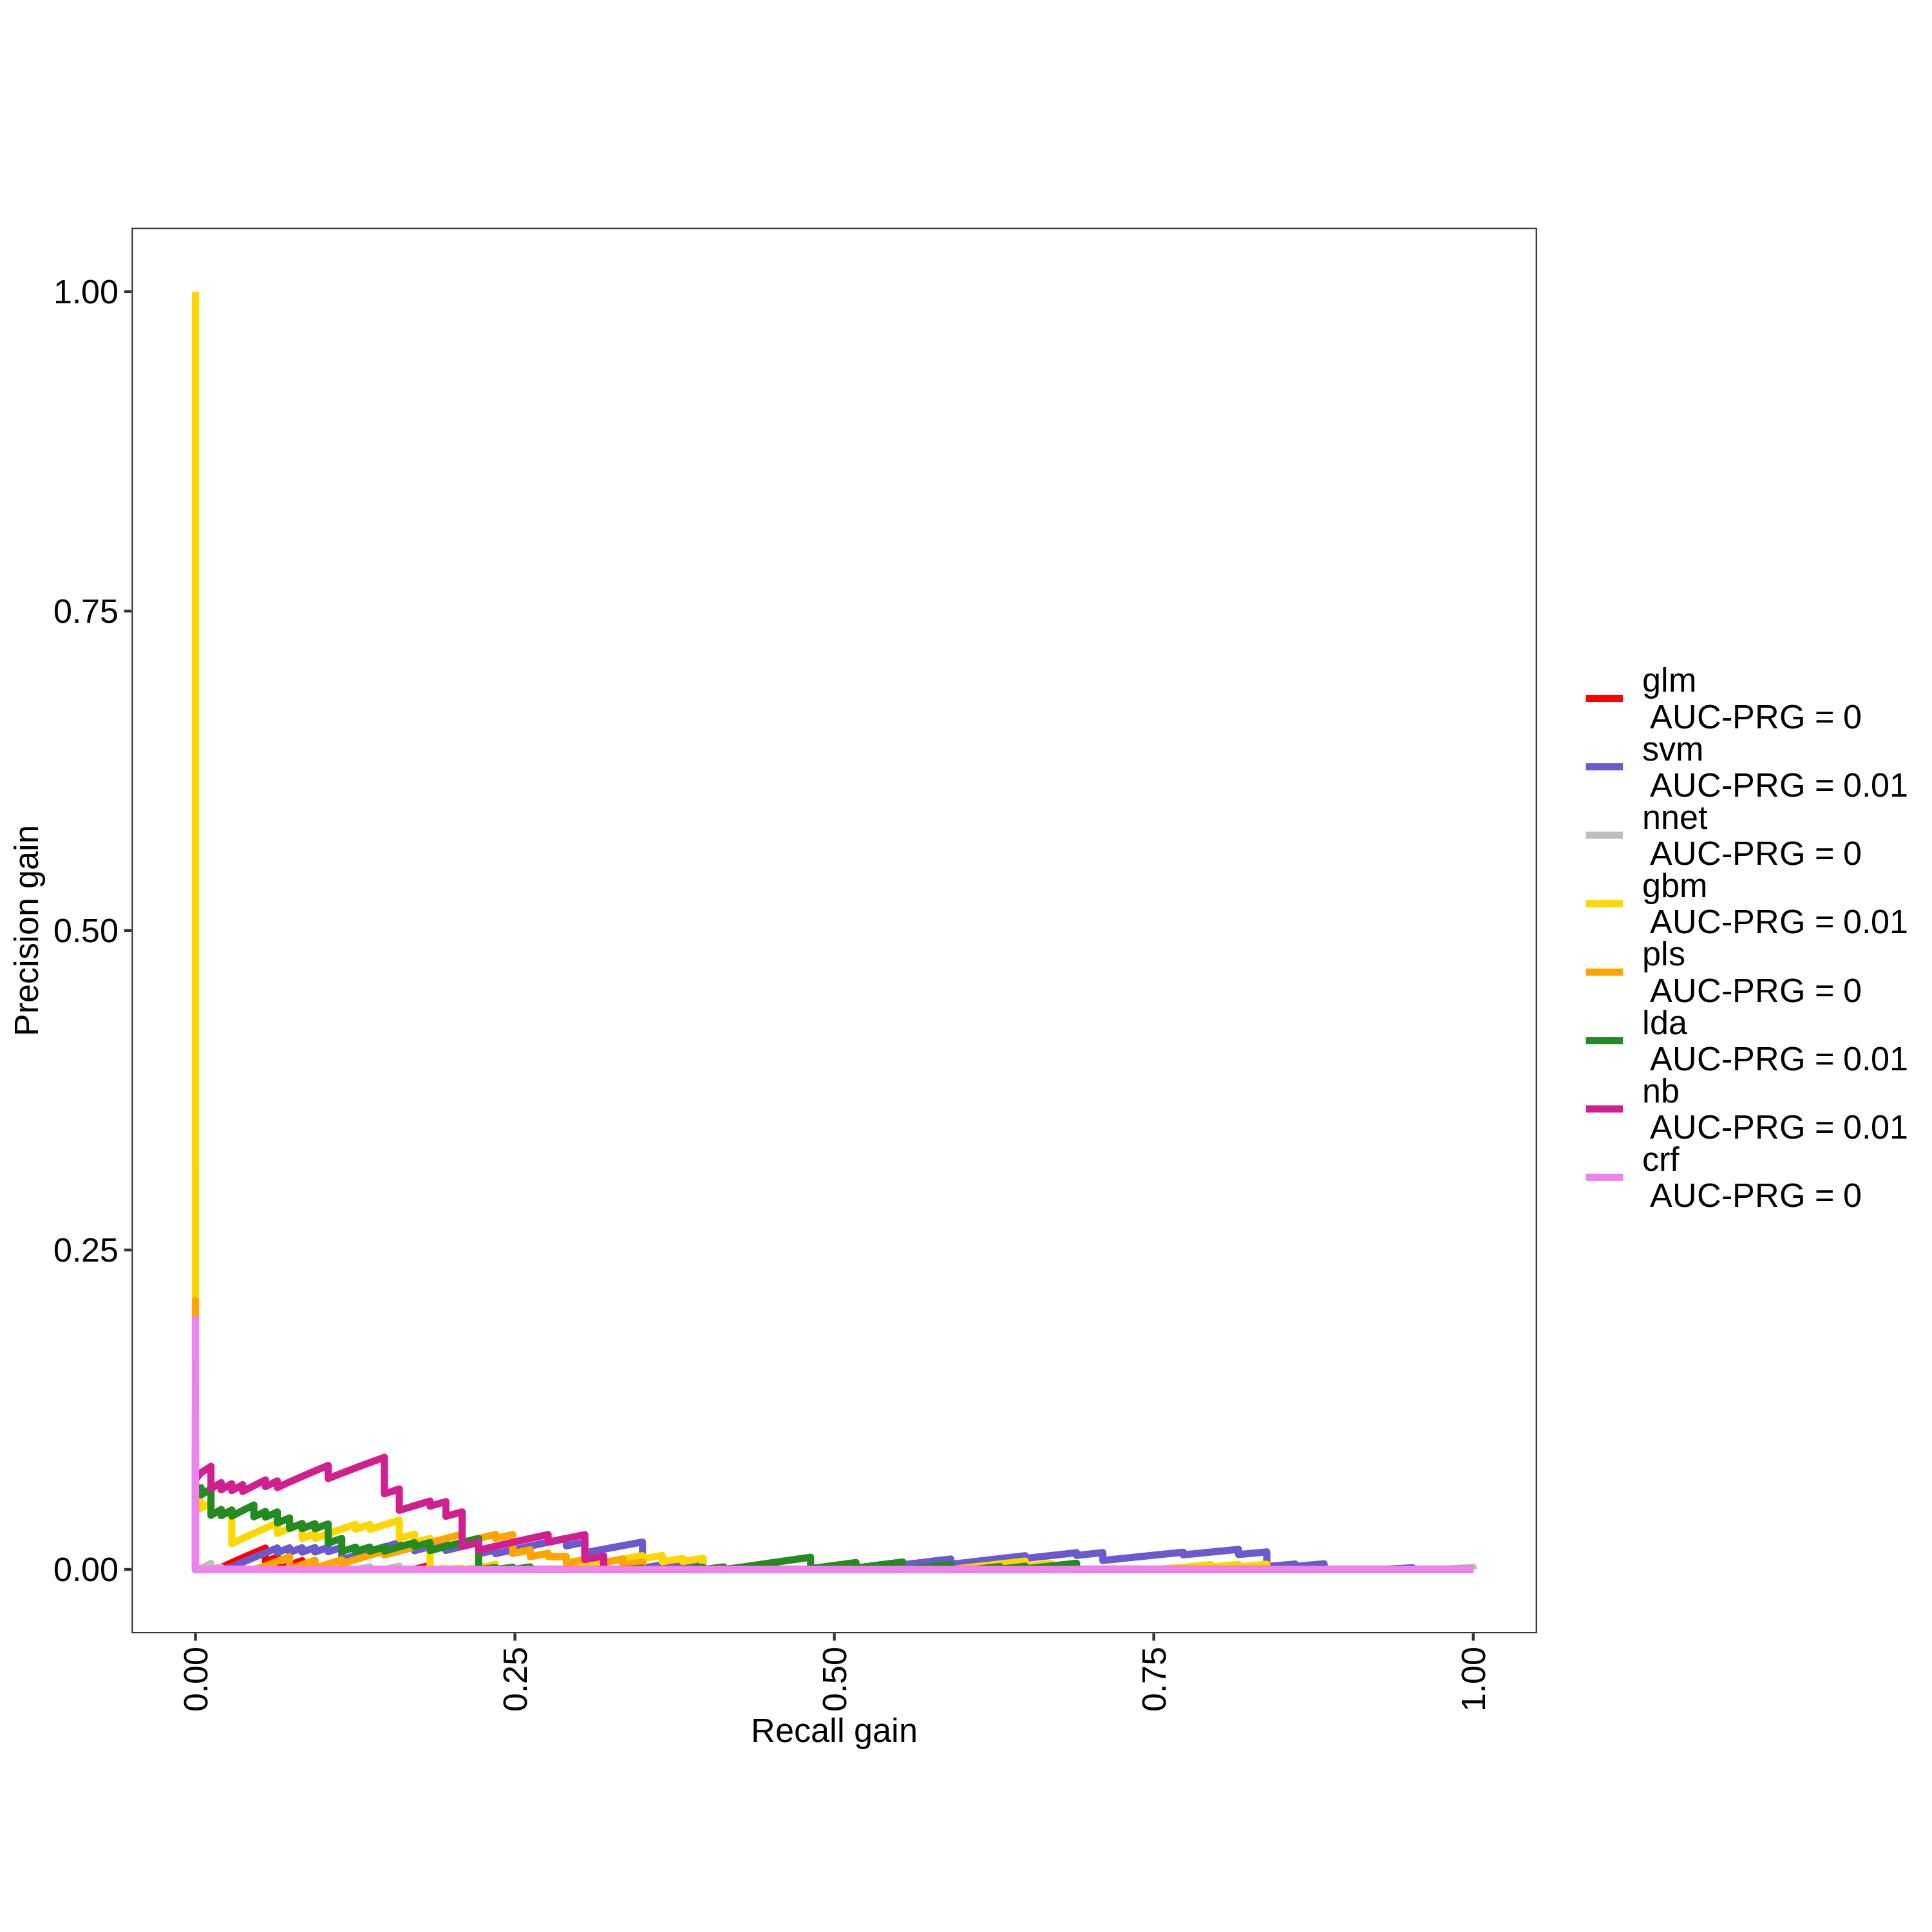

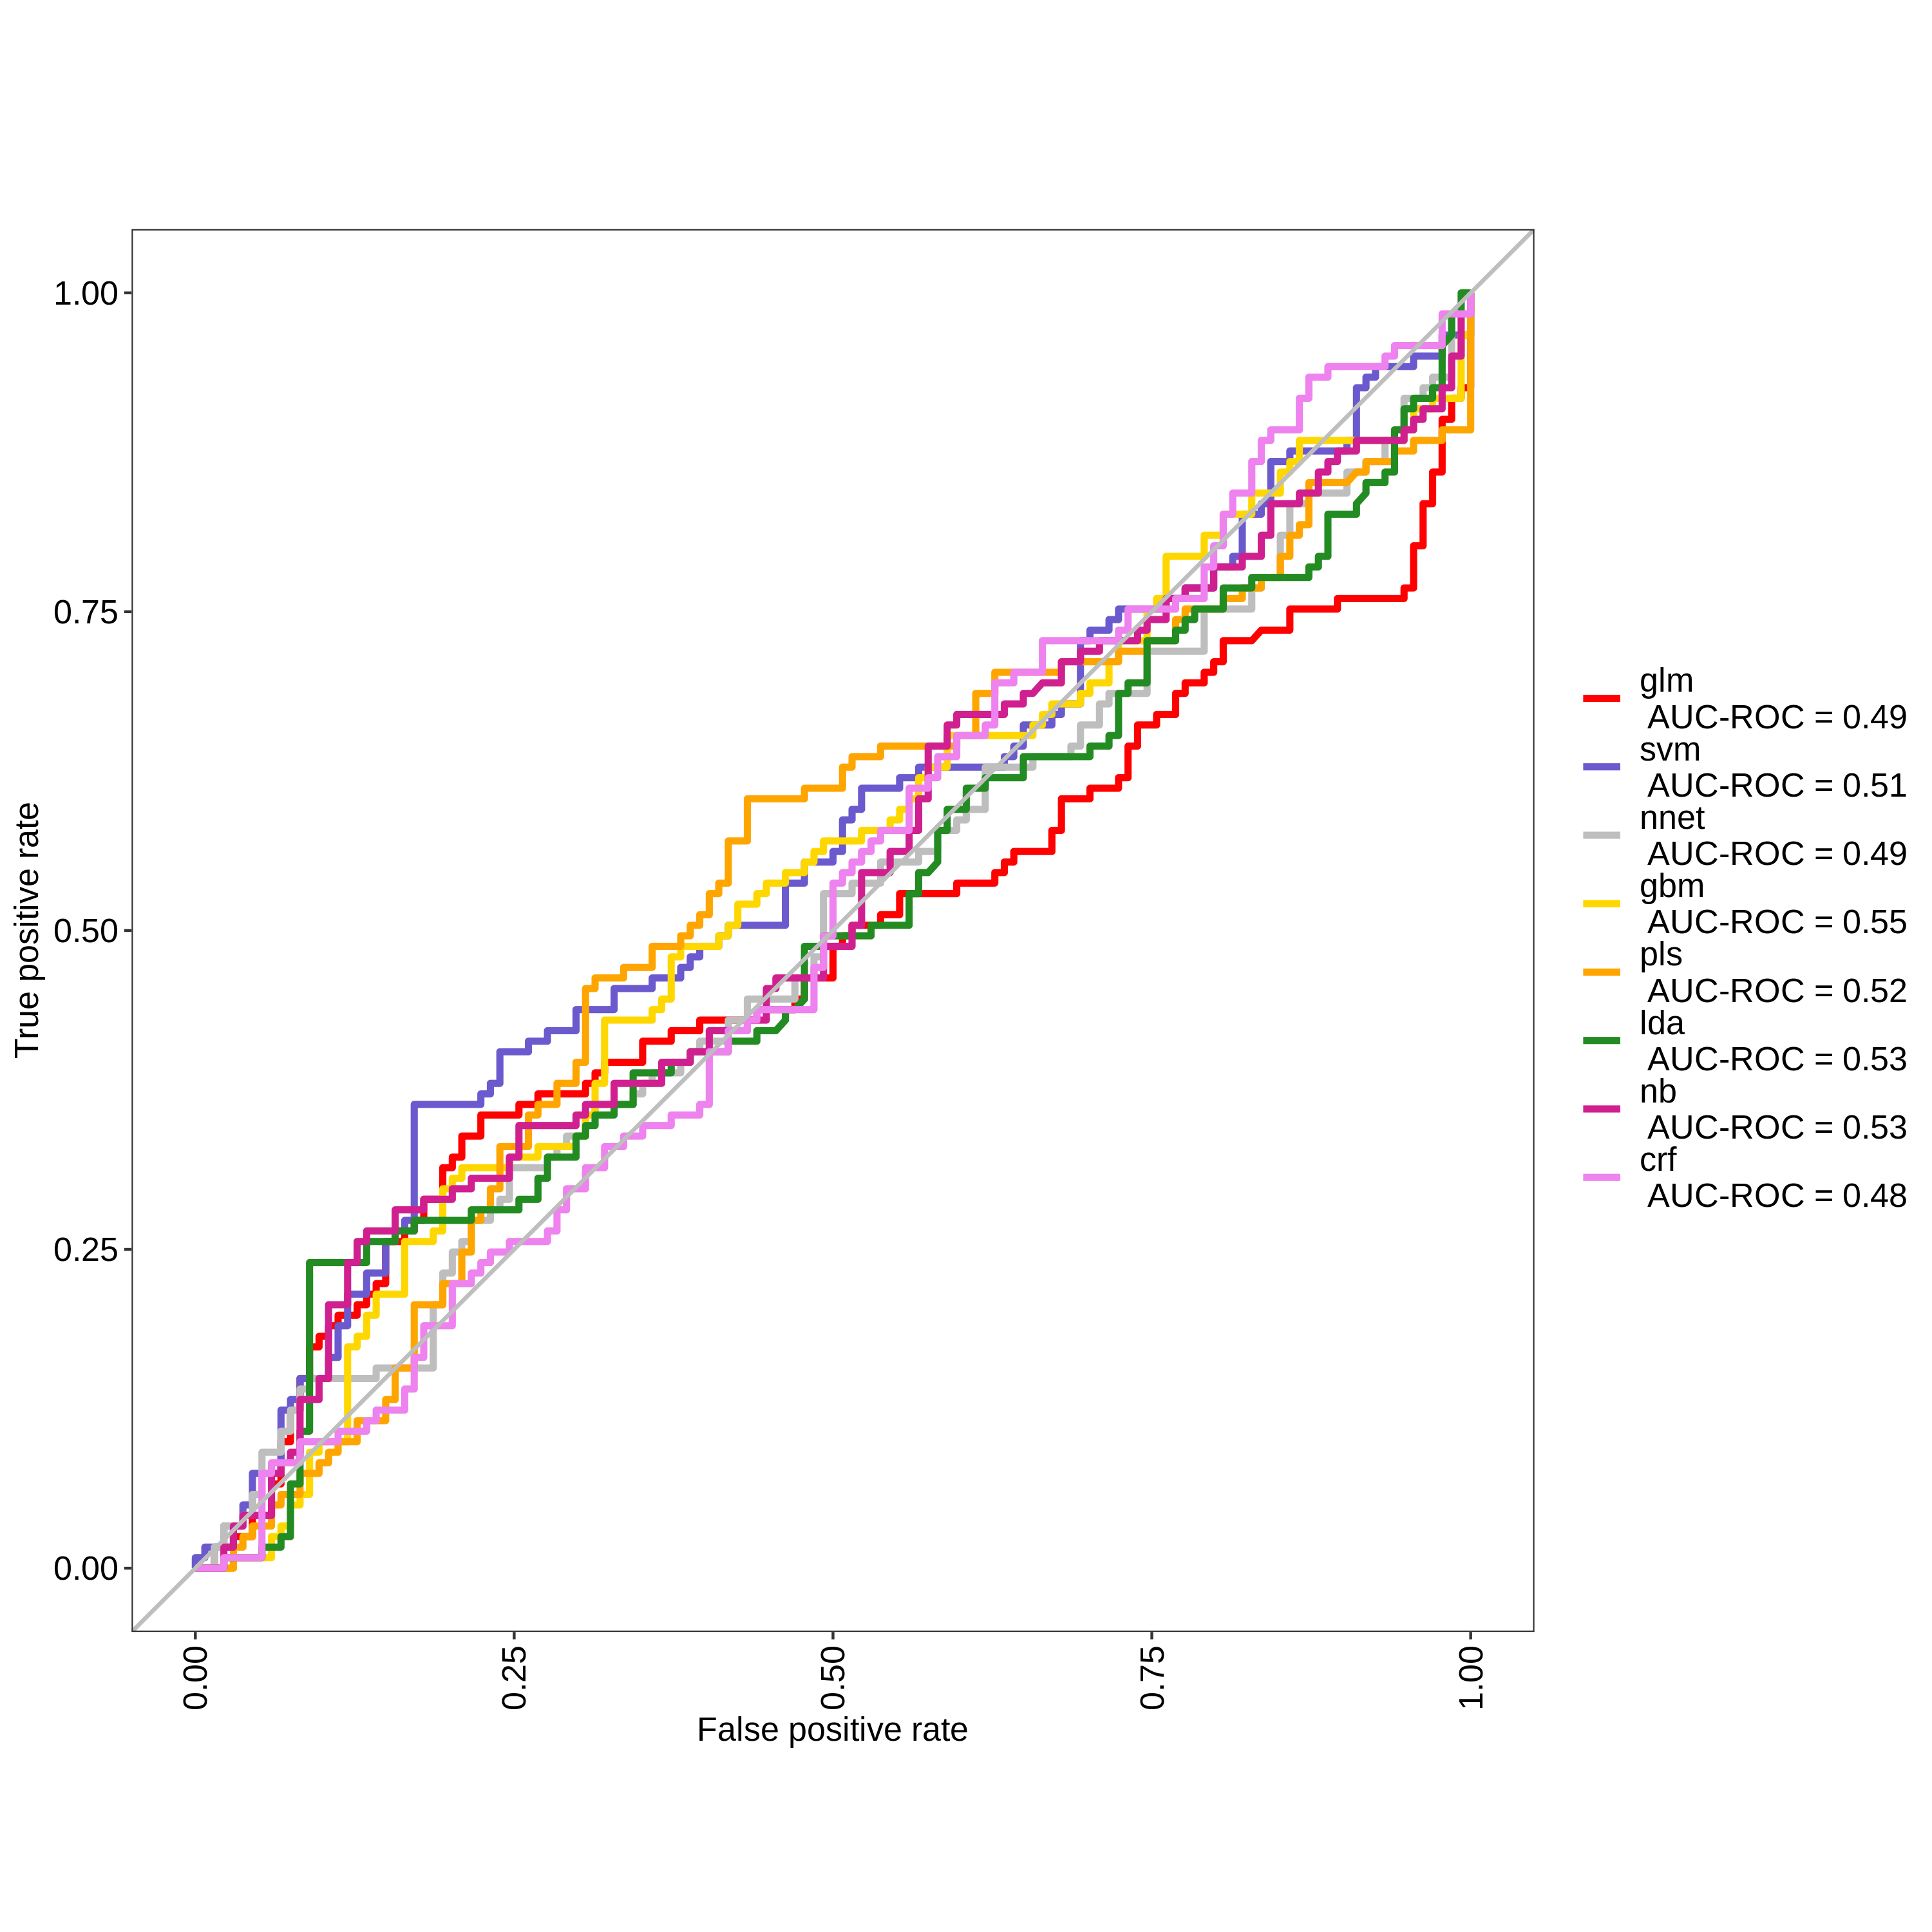

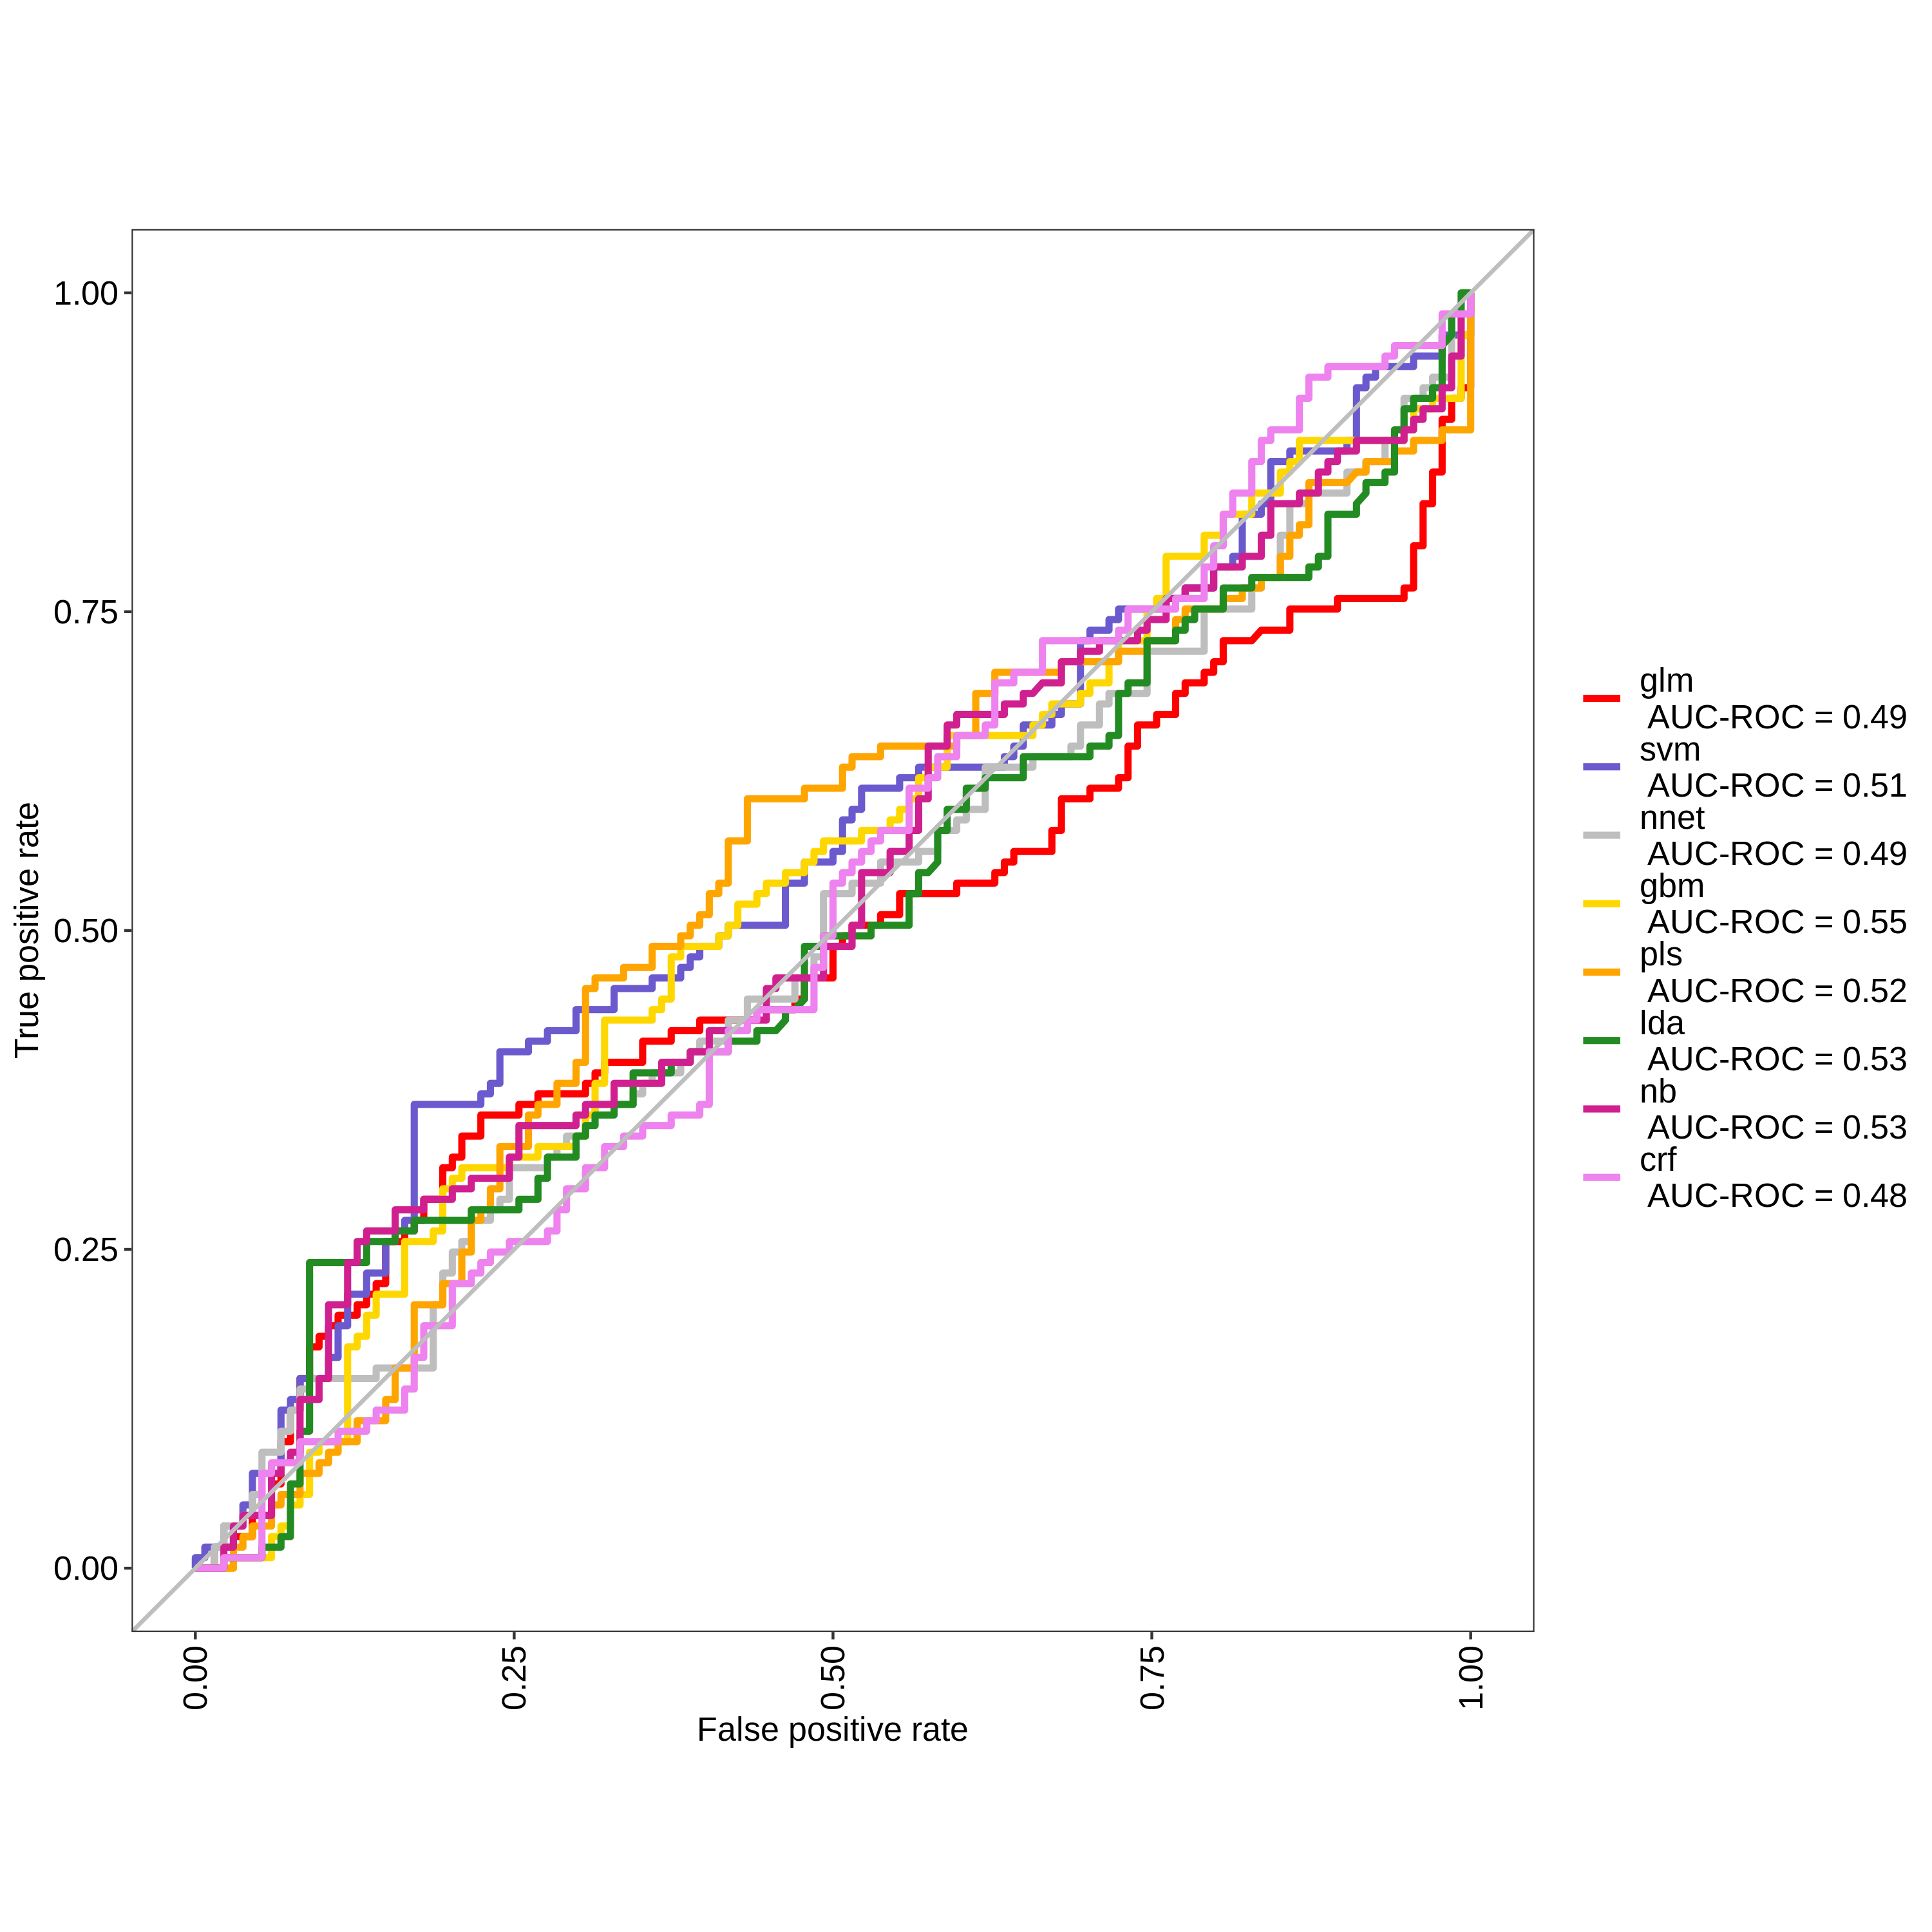

In [75]:
inp_glm <- train(Response ~ .,data=mod_inp_mat2,
              method="glmnet",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))
inp_svm <- train(Response ~ .,data=mod_inp_mat2,
              method="svmLinear2",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))
inp_nnet <- train(Response ~ .,data=mod_inp_mat2,
              method="nnet",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))
inp_gbm <- train(Response ~ .,data=mod_inp_mat2,
              method="gbm",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))
inp_pls <- train(Response ~ .,data=mod_inp_mat2,
              method="pls",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))
inp_lda <- train(Response ~ .,data=mod_inp_mat2,
              method="stepLDA",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))
inp_nb <- train(Response ~ .,data=mod_inp_mat2,
              method="naive_bayes",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))
inp_crf <- train(Response ~ .,data=mod_inp_mat2,
              method="cforest",
              trControl=ctrl,
              metric = "ROC",
              preProcess = c("scale", "center"))

options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)
res_glm <- evalm(list(inp_glm, inp_svm, inp_nnet, inp_gbm, inp_pls, inp_lda, inp_nb, inp_crf),
             gnames=c("glm", "svm", "nnet", "gbm", 
                      "pls", "lda", "nb", "crf"))
res_glm$roc